# Recommender Systems - Mini Challenge FS24

In this minichallenge we will explore a MovieLens dataset and implement several recommender systems and evaluation methods. Subsequently we will optimize these methods and compare the results. 

**Submission deadline:** 5.5.2024 23:59. 

## Guidelines for Implementation and Submission
- Code must be written in Python or R. The versions of all used packages must be given for reproducability.
- We develop numerous algorithms ourselves. Unless explicitly stated otherwise, only the following libraries may be used in Python: numpy, matplotlib, seaborn, pandas. In R only the base package, ggplot2, lattice, dplyr. 
- Follow good coding practices and write modular, reusable code.
- The submitted solution must contain all codes and the results. No code may be outsourced.
- If computation time is too long for productive prototyping and debugging work, it is recommended to reduce the dataset to a fraction of its original. However, final results should be calculated on the full dataset. 
- All plots must be fully labeled (title, axes, labels, colorbar, etc.) so that the plot can be easily understood.
- Each plot should be accompanied by a brief discussion, which explains the plot and captures the key insights that become visible.
- Only fully labeled plots with an accompanying discussion will be assessed.
- The last commit in your fork of the repo before the submission deadline counts as the submission.
- If you would like to submit and have the mini-challenge assessed, please send a short email to the subject expert (moritz.kirschmann@fhnw.ch) within 2 days after submission.
- Please do not delete, duplicate, or move the existing cells. This leads to problems during the correction. However, you may add as many additional cells as you like.

## Exercises

### Exercise 1 - A deep exploration of the dataset (17 points)
We will work with a subset of the MovieLens dataset. This subset is located under ``data/ml-latest-small``. Read the ``README.txt``carefully. 
Open the files. 
Create usefull data representations such as the the *User Item Matrix*.
Perform explorative data analysis. Describe the available data. Did you find duplicates or otherwise bad data? 

Generate lists of
- Top 20 movies by average rating
- Top 20 movies by number of views

Answer: 
- What is the range of the ratings? 
- Which genre has be rated how many times?
- How sparse is the User Rating Matrix?

Plot the following:
- How many users have rated how many movies
- Which rating is given how often on average
- Which rating is given how often on average per genre
- The rating distributions of 10 random movies
- The rating distributions of 3 movies that you have watched
- How many users give which average rating
- How often a movie was rated as a function of average rating
- A heatmap of the User Item Matrix
- A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings


#### Importing Data & Preprocessing

The first step is to read in the data and create relevant dataframes.

The following block...
- Converts all `genres` of movies into dummy variables.
- Gives the movies a new Id `movieId_seq` which will start at 1 and iterate all the way through the number of movies in the dataset.
    - This measure has to be taken to later on work with `numpy` indices when we lose context of the `pandas` Ids since the `ml-latest-small` set sometimes skips Id increments.
- Creates a `df_movieratings` in which every rating represents one row. The dataframe merges the `ratings.csv` and `movies.csv` together to allow pivoting into a utility matrix (user item rating matrix).
- Creates the user item matrix (UIM) where each row represents a user, each column an item (movie), and every value inside the matrix a rating given by the user on an item.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_FOLDER = 'data/ml-latest-small/'

df_movies = pd.read_csv(DATA_FOLDER + 'movies.csv')
df_ratings = pd.read_csv(DATA_FOLDER + 'ratings.csv')

genres_dummies = df_movies['genres'].str.get_dummies(sep='|')
df_movies['genres_list'] = df_movies['genres'].str.split('|')

df_movies['movieId_seq'] = range(1, len(df_movies) + 1)

genre_dummies = df_movies['genres_list'].str.join('|').str.get_dummies()

df_movies = pd.concat([df_movies, genre_dummies], axis=1)

df_movies = df_movies.drop(columns=['genres', 'genres_list'])

df_movieratings = pd.merge(df_ratings, df_movies, on='movieId')

sns.set_palette('crest')

user_item_matrix = df_movieratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

#### Top 20 Movies by average rating

In [2]:
df_movieratings.groupby('title').agg(
    rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).sort_values(by=['rating', 'rating_count'], ascending=False).head(20)

,rating,rating_count
title,,
Belle époque (1992),5.0,2
Come and See (Idi i smotri) (1985),5.0,2
Enter the Void (2009),5.0,2
Heidi Fleiss: Hollywood Madam (1995),5.0,2
Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976),5.0,2
Lamerica (1994),5.0,2
Lesson Faust (1994),5.0,2
'Salem's Lot (2004),5.0,1
12 Angry Men (1997),5.0,1


#### Top 20 Movies by number of views

In [3]:
df_movieratings.groupby('title').agg(
    rating_count=('rating', 'count')
).sort_values(by='rating_count', ascending=False).head(20)

,rating_count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


#### Range of Ratings

In [4]:
possible_ratings = df_movieratings['rating'].sort_values().unique()
print(f'Range: {possible_ratings[0]} - {possible_ratings[-1]}')

Range: 0.5 - 5.0


#### How sparse is the User Rating matrix?
To calculate the sparsity I will divide the number of recorded ratings (`df_movieratings.shape[0]`) by the dimensions of the User Rating matrix (`user_item_matrix.shape[0] * user_item_matrix.shape[1]`) and take its complement percentage.

In [5]:
sparsity = 1 - df_movieratings.shape[0] / (user_item_matrix.shape[0] * user_item_matrix.shape[1])
print(f'Sparsity: {sparsity:.2%}')

Sparsity: 98.30%


The User Rating consists of `98.3%` missing ratings so it is very sparse.

#### Number of Users and Ratings
**How many users have rated how many movies?**

To answer this question I plot the frequencies of the rated movies, movies without any ratings and the number of users.

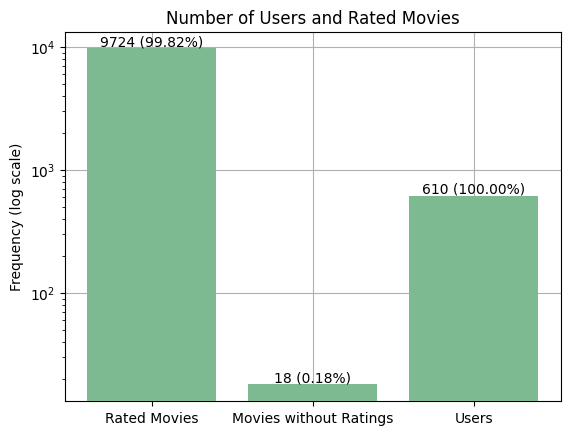

In [6]:
n_movies = df_movies['movieId'].nunique()
n_users = df_ratings['userId'].nunique()
n_rated_movies = df_ratings['movieId'].nunique()

values = [n_rated_movies, n_movies-n_rated_movies, n_users]
percentages = [(100 * value / total if total > 0 else 0) for value, total in zip(values, [n_movies, n_movies, n_users])]

fig, ax = plt.subplots()

bars = ax.bar(['Rated Movies', 'Movies without Ratings', 'Users'],
              values,
              zorder=3)

for bar, value, percentage in zip(bars, values, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, 
            f'{value} ({percentage:.2f}%)', 
            ha='center', va='bottom' if height > 0 else 'top')

ax.grid(True, zorder=0)
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Number of Users and Rated Movies')
ax.set_yscale('log')

plt.show()

There are `9724` rated movies and `610` users that rated. `18` movies have no rating.

This means there are much more movies than users so the `18` movies are very much plausible.

#### Rating Averages
**Which rating is given how often on average?**

This question can be answered by overall looking at the average and the frequency of each rating:

In [12]:
print(f'Average overall rating: {df_ratings["rating"].mean():.2f}')

Average overall rating: 3.50


This is also suspected as `3.5` is the **expected value** for the MovieLens rating scale of 0-5.

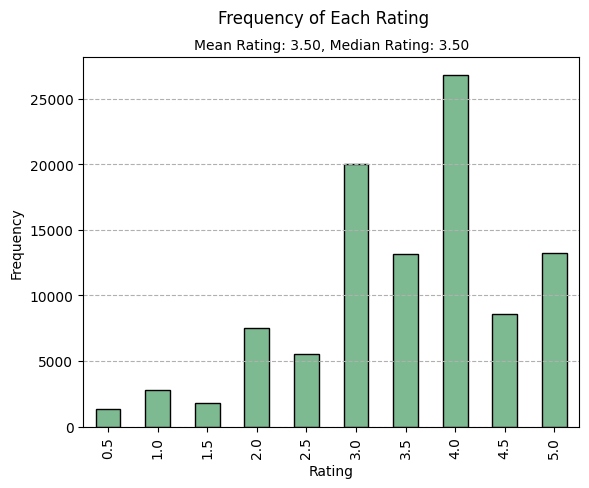

In [13]:
rating_counts = df_ratings['rating'].value_counts().sort_index()

fig, ax = plt.subplots()
rating_counts.plot(kind='bar', ax=ax, edgecolor='black')

mean_rating = df_ratings['rating'].mean()
median_rating = df_ratings['rating'].median()

fig.suptitle('Frequency of Each Rating')
ax.set_title(f'Mean Rating: {mean_rating:.2f}, Median Rating: {median_rating:.2f}', fontsize=10)
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.grid(axis='y', linestyle='--')

plt.show()

The distribution overall shows a rather right-skewed distribution which is also an expected observation since human ratings usually contain a **popularity bias** and **selection bias**. 
This means users tend to only consume movies which they will like; Perhaps a friend with the same interests *recommended* the movie to them. Additionally, users also tend to only rate positive experienes - This may explain the skewness of this distribution.

#### Rating Averages per Genre
**Which rating is given how often on average per genre?**

To now look at how the same distribution looks but on a genre-level I plot the same frequency plot but for all genres.

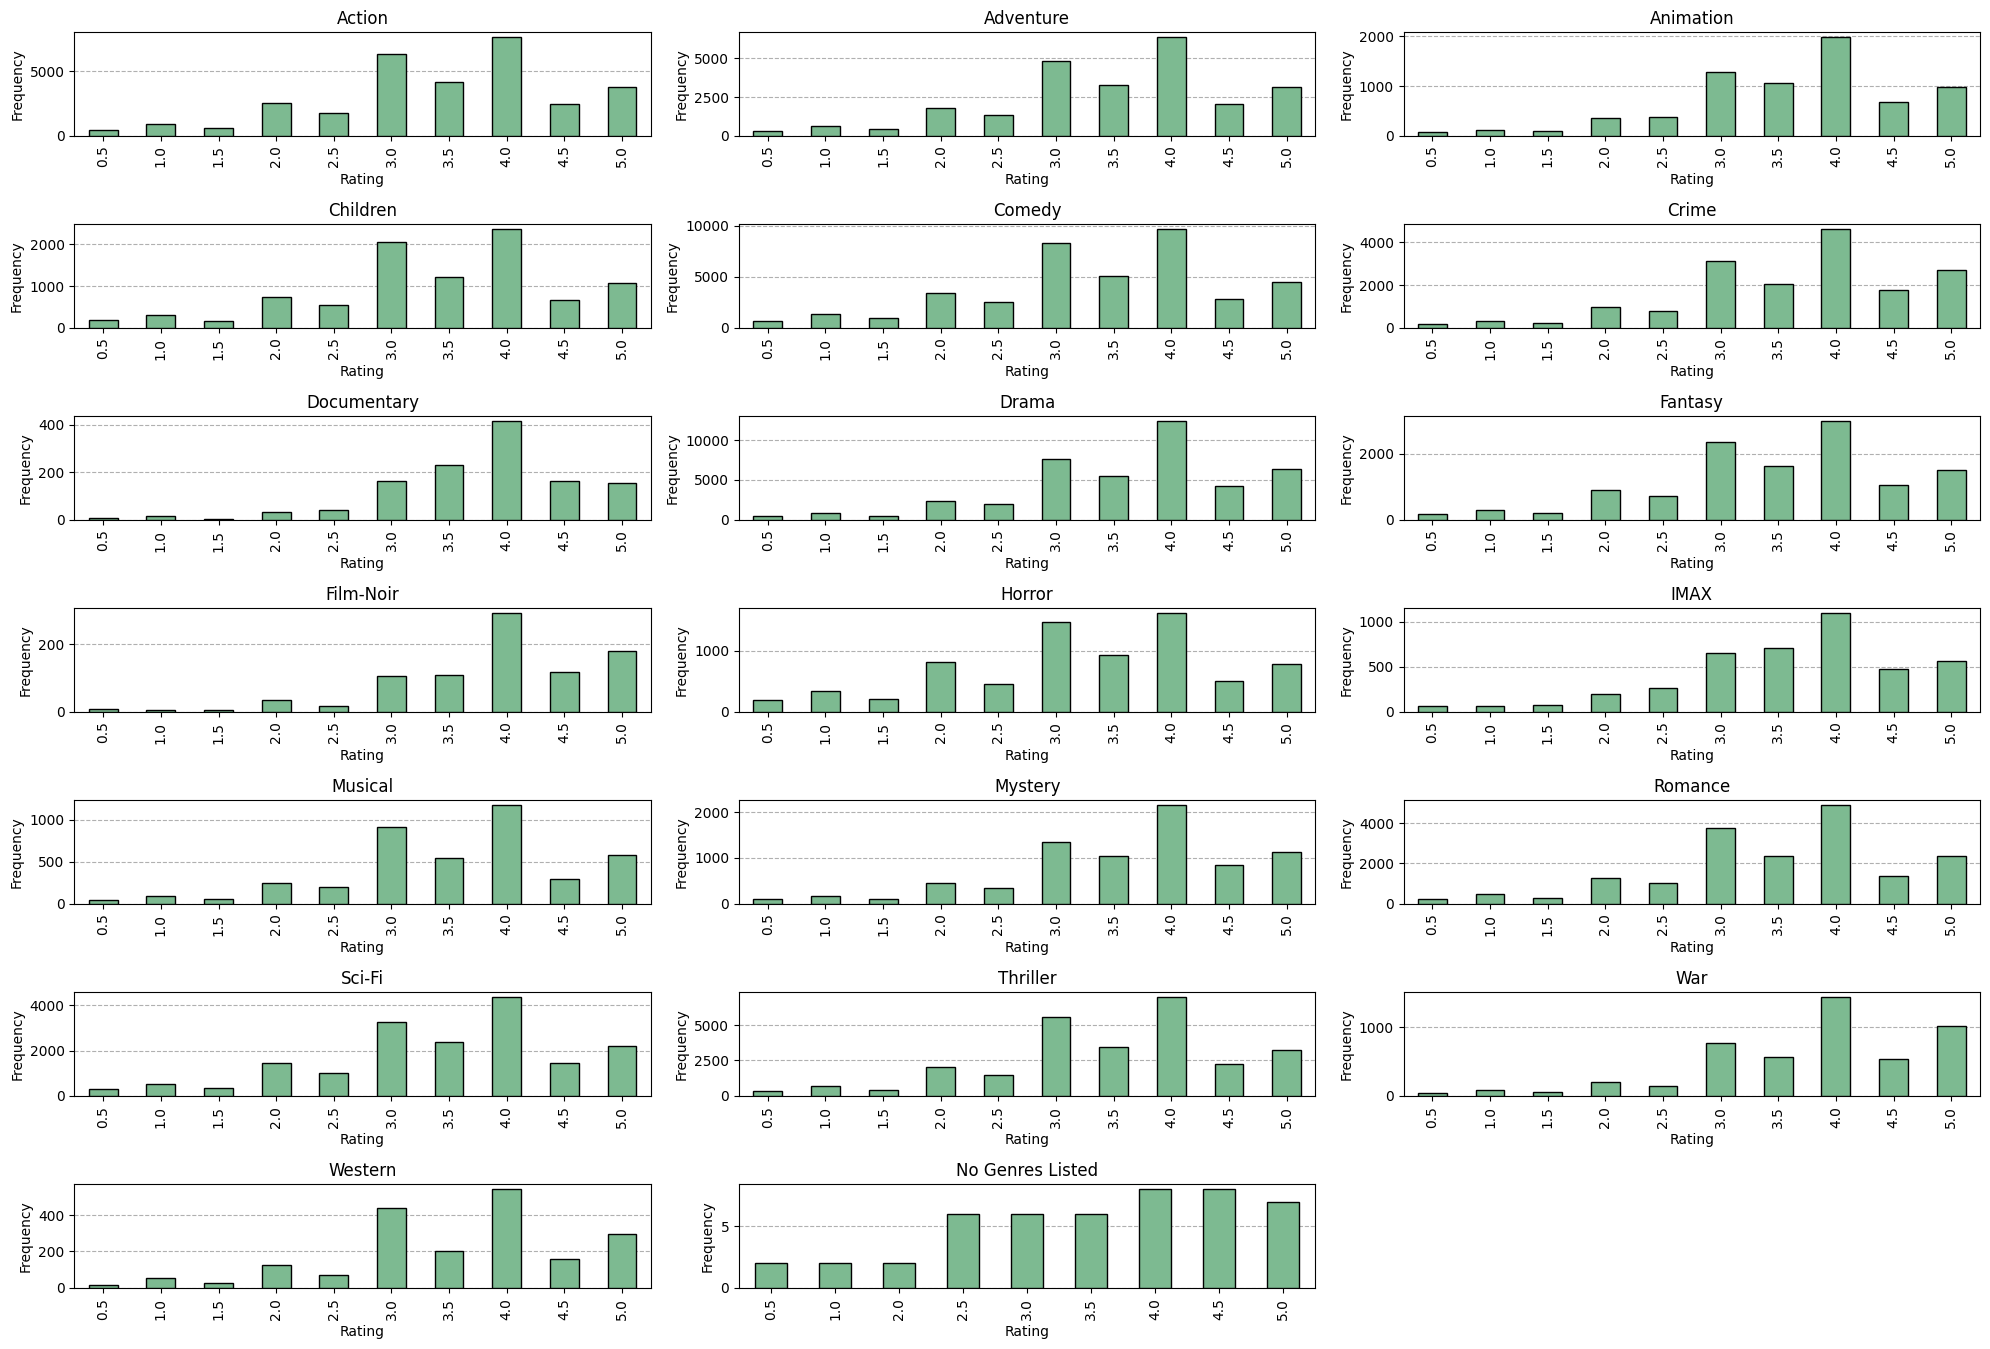

In [14]:
genres = df_movieratings.columns[7:]

plt.figure(figsize=(20, 15))
n_rows = len(genres) // 3 + (len(genres) % 3 > 0) + 1
n_cols = 3

for i, genre in enumerate(genres, start=1):
    plt.subplot(n_rows, n_cols, i)
    genre_ratings = df_movieratings[df_movieratings[genre] == 1]['rating']
    rating_counts = genre_ratings.value_counts().sort_index()

    if not rating_counts.empty:
        rating_counts.plot(kind='bar', edgecolor='black', zorder=3)
        plt.title(genre)
        plt.xlabel('Rating')
        plt.ylabel('Frequency')
    else:
        plt.title(genre + " (No Ratings)")
    plt.grid(axis='y', linestyle='--', zorder=0)

plt.subplot(n_rows, n_cols, len(genres) + 1)
no_genres_mask = df_movieratings[genres].sum(axis=1) == 0
no_genre_ratings = df_movieratings[no_genres_mask]['rating']
no_genre_rating_counts = no_genre_ratings.value_counts().sort_index()

no_genre_rating_counts.plot(kind='bar', edgecolor='black', zorder=3)
plt.title("No Genres Listed")
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.grid(axis='y', linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

The genres generally show the same observation. Most of them have a high number of the rating `3` and `4` which will average out at around `3.5` - the expected value.

Genres like **Film-Noir**, and also **IMAX** to some extend, show a surprisingly high amount of ratings of `4` - Though, especially Film-Noir has a rather low count in ratings in general so this observation has to be taken with a grain of salt. 

#### Rating Distributions of 10 Random Movies
**How does the rating distributions of 10 random movies look?**

In this exploration I sample 10 random movies and look at their ratings.

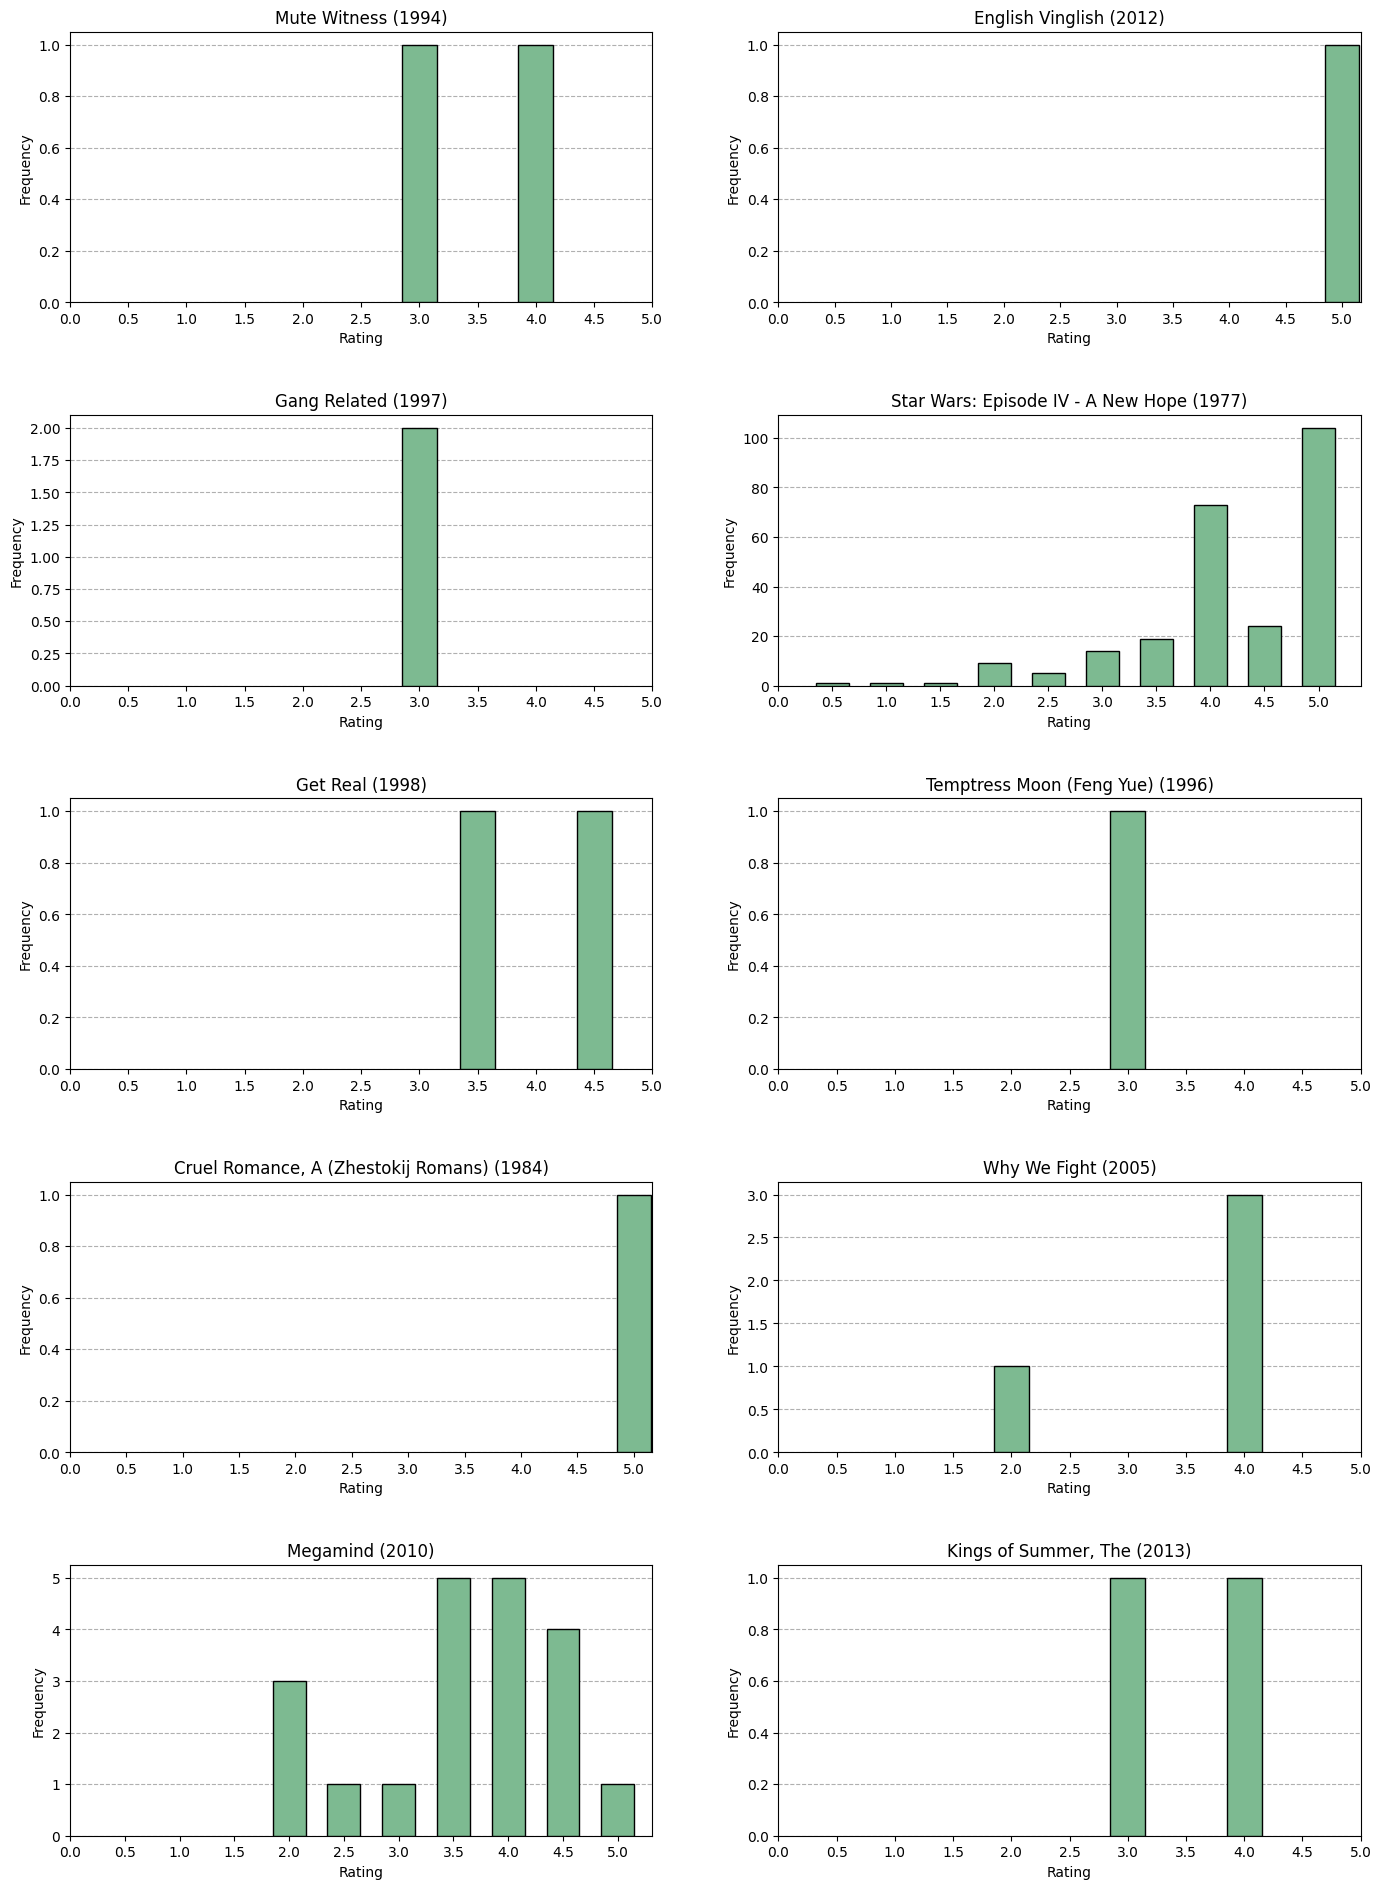

In [15]:
sampled_movies = df_movieratings['movieId'].drop_duplicates().sample(n=10, random_state=1337)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=6.0)

axes = axes.flatten()

for i, movieId in enumerate(sampled_movies):
    movie_ratings = df_movieratings[df_movieratings['movieId'] == movieId]['rating']
    rating_counts = movie_ratings.value_counts().sort_index()
    
    axes[i].bar(rating_counts.index, rating_counts.values, edgecolor='black', zorder=3, width=0.3)
    movie_title = df_movieratings.loc[df_movieratings['movieId'] == movieId, 'title'].iloc[0]
    axes[i].set_title(movie_title)
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(np.arange(0, 5.5, 0.5))
    
    axes[i].grid(axis='y', linestyle='--', zorder=0)

for ax in axes[i+1:]:
    ax.axis('off')

plt.show()

Most of the sampled movies only have a handful of ratings. The only movie which shows a similar distribution to the overall distribution is **Forrest Gump** which is the most rated movie in this dataset. For the other sampled movies we can also see that the few ratings they have usually are in the neighborhood of the mean of `3.5`. The movie **The Brothers Solomon** stands out as a very low rated movie with its only rating being at `0.5`.

#### Rating Distributions of 3 Movies I have watched
**The rating distributions of 3 movies that you have watched**

For this observation I will look at the rating distributions of my 3 favorite movies:
- American Psycho
- Blade Runner 2049
- Wolf of Wallstreet

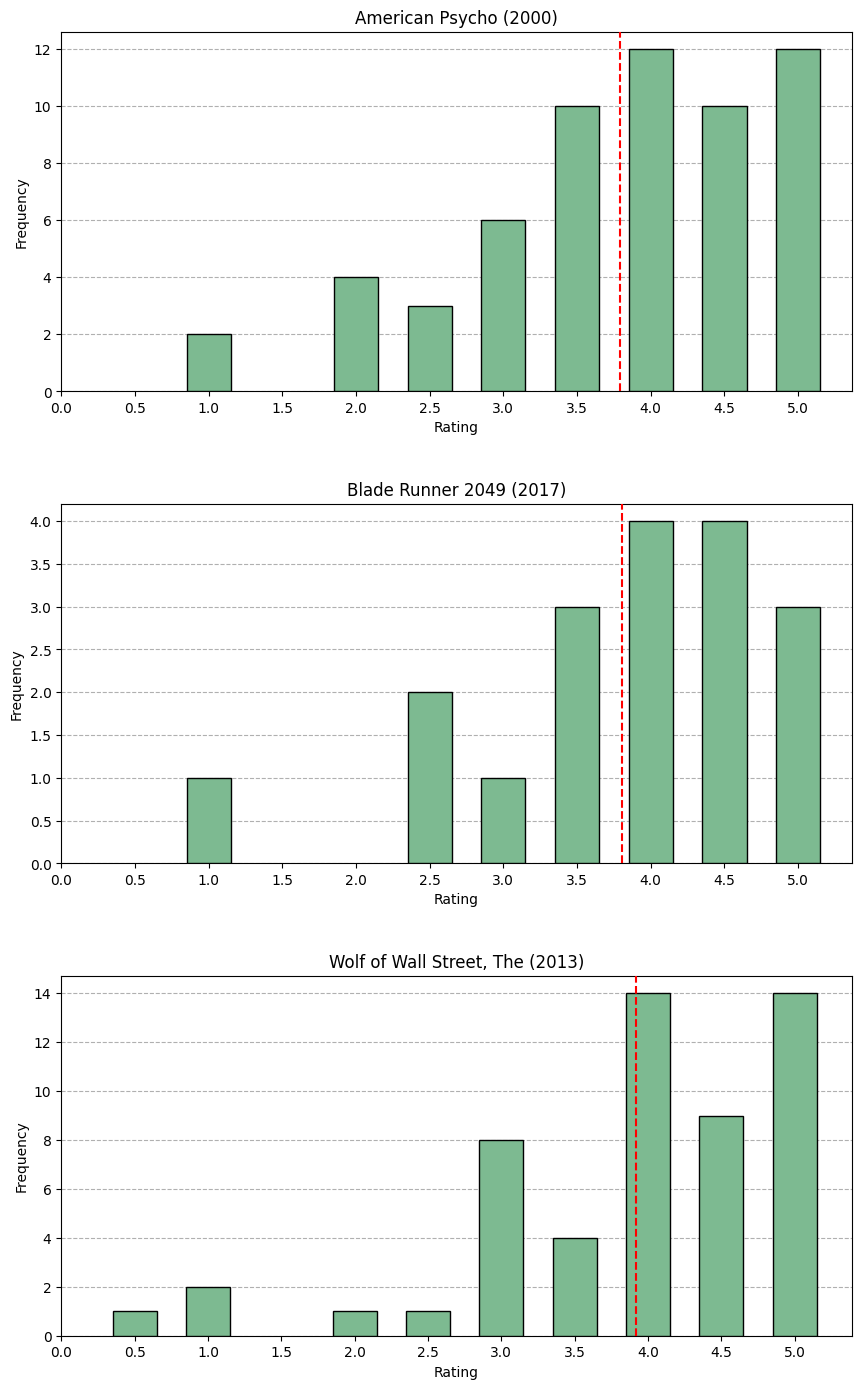

In [16]:
my_movies = ['American Psycho (2000)',
             'Blade Runner 2049 (2017)',
             'Wolf of Wall Street, The (2013)']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)

for i, movie_title in enumerate(my_movies):
    movie_ratings = df_movieratings[df_movieratings['title'] == movie_title]['rating']
    rating_counts = movie_ratings.value_counts().sort_index()
    
    axes[i].bar(rating_counts.index, rating_counts.values, edgecolor='black', zorder=3, width=0.3)
    axes[i].axvline(x=movie_ratings.mean(), color='red', linestyle='--', label='Mean Rating', zorder=3)
    axes[i].set_title(movie_title)
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(np.arange(0, 5.5, 0.5))
    
    axes[i].grid(axis='y', linestyle='--', zorder=0)
    
plt.show()

My favorite movies are very popular and we can see that their mean rating clearly stands above the overall mean rating of `3.5`. Among my 3 favorite movies we can observe that **Wolf of Wallstreet** seems to have the most high ratings among them, closely next to **American Psycho**. The movie **Blade Runner 2049** also has good ratings but generally has fewer ratings in frequency - This might be because it came out the most recent.

#### Number of Users per Average Rating
**How many users give which average rating?**

To get a good overview of how many users are behind each rating this block will create a distribution showing the number of users per rating in a resolution of `0.1` steps.

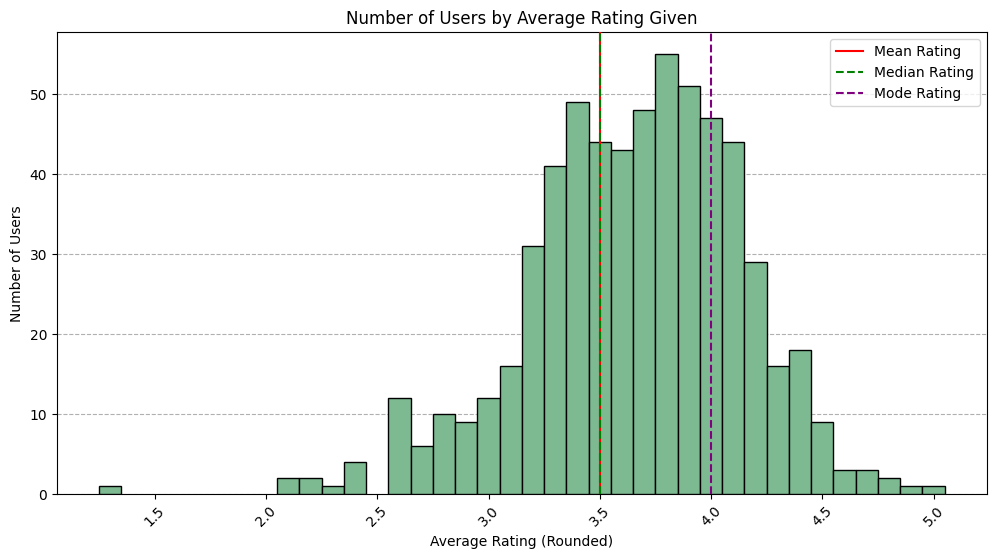

--- Distribution Metrics ---
Mean: 3.501556983616962
Median: 3.5
Mode: 4.0


In [17]:
user_avg_ratings = df_movieratings.groupby('userId')['rating'].mean().reset_index(name='avg_rating')

user_avg_ratings['avg_rating_rounded'] = user_avg_ratings['avg_rating'].round(1)

avg_rating_counts = user_avg_ratings['avg_rating_rounded'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

plt.bar(avg_rating_counts.index, avg_rating_counts.values, zorder=3, width=0.1, edgecolor='black')

plt.axvline(x=df_ratings['rating'].mean(), color='red', label='Mean Rating', zorder=3)
plt.axvline(x=df_ratings['rating'].median(), color='green', linestyle='--', label='Median Rating', zorder=3)
plt.axvline(x=df_ratings['rating'].mode().iloc[0], color='purple', linestyle='--', label='Mode Rating', zorder=3)
plt.legend()

plt.title('Number of Users by Average Rating Given')
plt.xlabel('Average Rating (Rounded)')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', zorder=0)
plt.show()

print('--- Distribution Metrics ---')
print(f'Mean: {df_ratings["rating"].mean()}')
print(f'Median: {df_ratings["rating"].median()}')
print(f'Mode: {df_ratings["rating"].mode().iloc[0]}')

The ratings look nearly normally distributed, the average rating given the most is `3.8`. The distribution is slightly more left skewed and therefore the mean rating gets pulled further from the mode.

#### Number of Movie Ratings as a function of Average Rating
**How often a movie was rated as a function of average rating**

To see how the average movie gets rated I will use a kernel density plot with the marginal distributions of the underlying scatters.

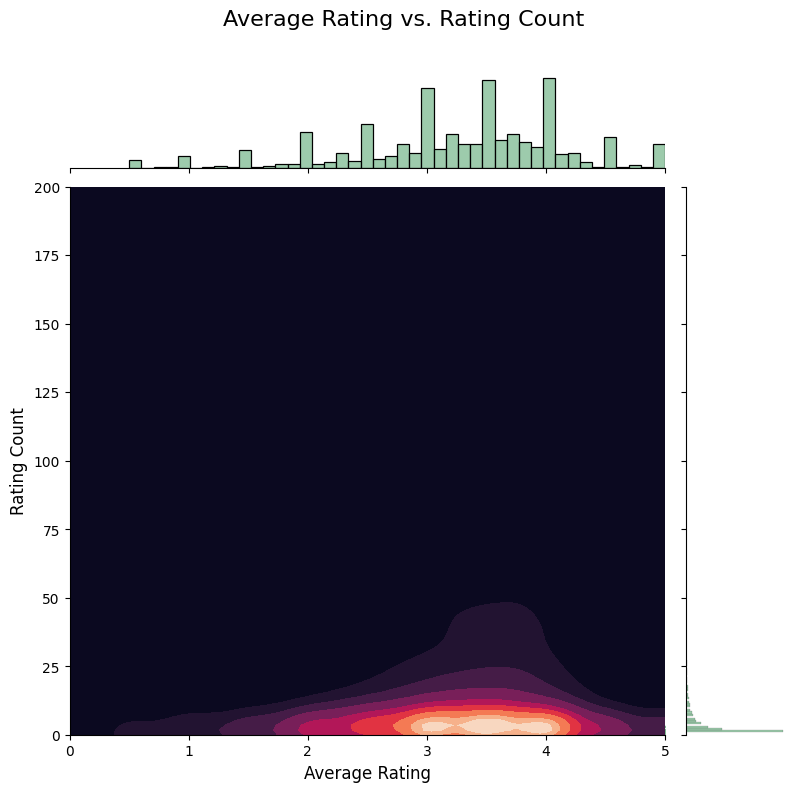

In [19]:
movie_stats = df_movieratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

g = sns.jointplot(x='avg_rating', y='rating_count', data=movie_stats, kind='scatter', height=8)
g.plot_joint(sns.kdeplot, fill=True, clip=((0, 5), (0, 400)), thresh=0, levels=10, cmap="rocket")
g.set_axis_labels('Average Rating', 'Rating Count', fontsize=12)
plt.ylim(0, 200)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Average Rating vs. Rating Count', fontsize=16)
plt.show()

The plot also shows that most of the average movie ratings lie between `3` and `4`. The brightest density level also shows a "bubble" in the center of the two, meaning it lies at `3.5`. Another interesting observation is the histogram on the x-axis, showing how integer ratings have a higher frequency than granular ratings between. Users probably found it easier to rate movies with integer numbers and didn't put too much thought into the process of rating that would add decimals.

#### User Item Matrix (UIM)
**A heatmap of the User Item Matrix**

The following heatmap shows the entirety of the User Rating Matrix. Every row represents a user and every column an item. The following numbers on the axes show arbitrary Ids that get selected by `seaborn` - They are just a rough indication of where the heatmap shows which movies or users. 

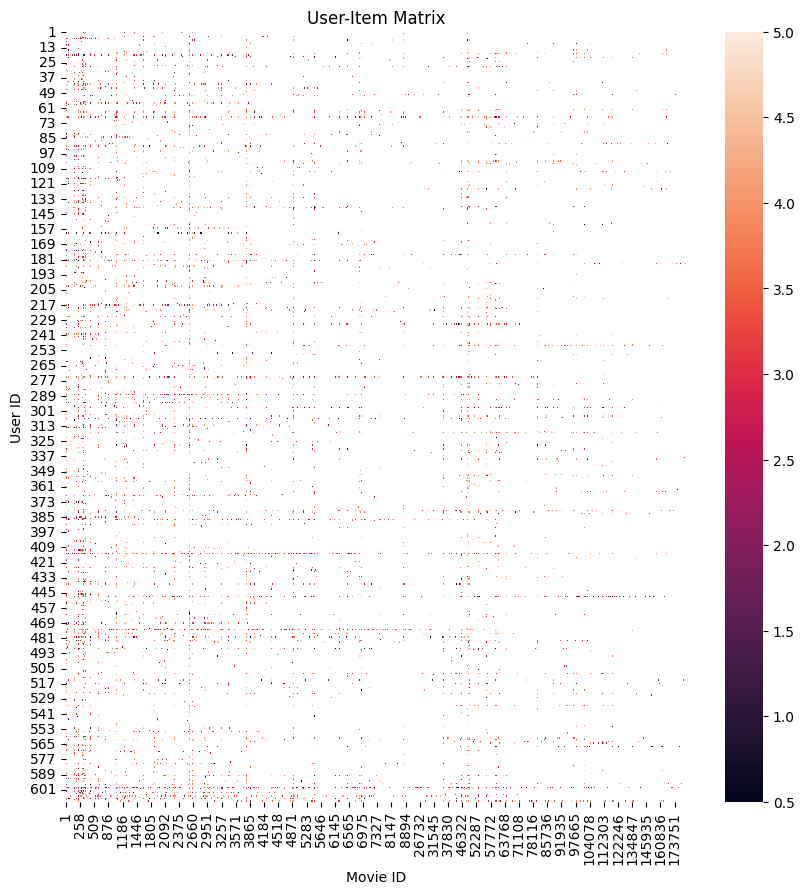

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(user_item_matrix)
plt.title('User-Item Matrix')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()

Since the matrix shows all ratings of the `610` users and `9724` items it is quite hard to make detailed assumptions. But generally we can see horizontal "lines" of users that like to rate movies a lot and vertical "lines" of movies that get rated a lot. For example, Forrest Gump, the most rated movie in the data set has the Id `356` - This Id is in one of the few visible lines between the shown Movie ID `258` and `509`.

#### User Item Matrix (UIM) for the 100 Most Rated movies for the 50 Users with most Ratings
**A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings**

This heatmap shows the User Rating Matrix for only the 100 most rated movies and 50 users who rate the most so its details should be clearer.

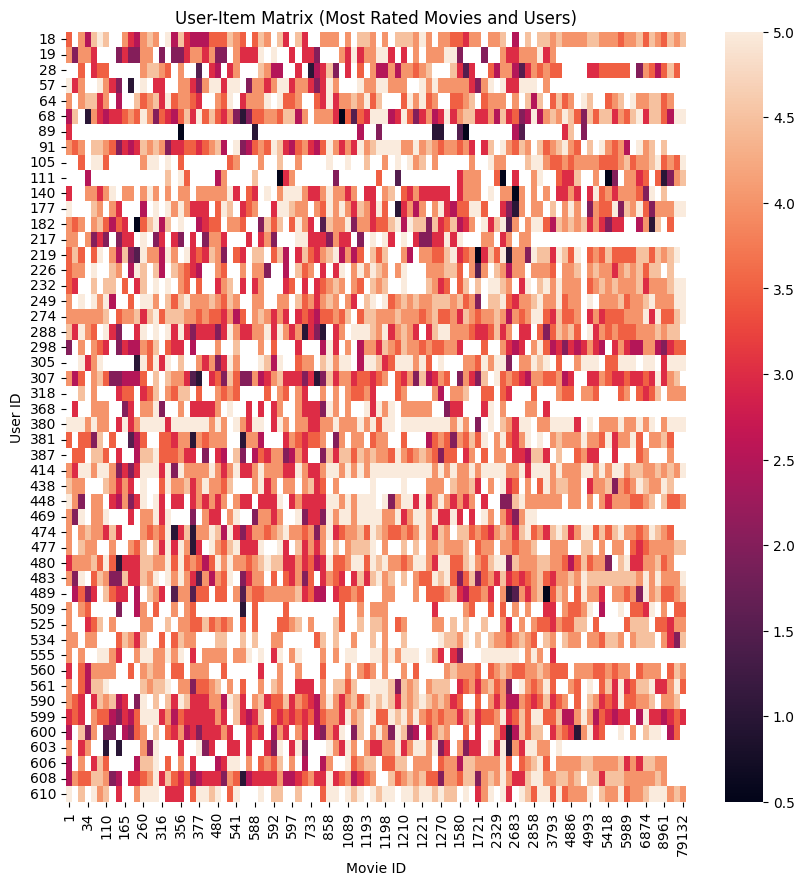

In [21]:
n_most_rated = 100
n_most_rated_users = 50

most_rated_movies = df_movieratings['movieId'].value_counts().head(n_most_rated).index
most_rated_users = df_movieratings['userId'].value_counts().head(n_most_rated_users).index

df_most_rated = df_movieratings[
    df_movieratings['movieId'].isin(most_rated_movies) &
    df_movieratings['userId'].isin(most_rated_users)
]

df_most_rated_features = df_most_rated.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

plt.figure(figsize=(10, 10))
sns.heatmap(df_most_rated_features)
plt.title('User-Item Matrix (Most Rated Movies and Users)')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()

As expected we now can see a much less sparse matrix since we plot the most rated movies and most rating users.

An interesting observation in this plot especially is User `89` who only has a few ratings compared to the other users but of the movies they rated almost only low ratings below `1` seem to have been given.

#### Result Gathering (Exercise 10)
This following class controls the gathering of results. It belongs to exercise 10 which will compare all following Recommenders.

In [79]:
class ResultStore:
    def __init__(self):
        self.df = pd.DataFrame(columns=[
            'recommender_name', 'rmse', 'best_parameters', 'average_precision_at_k', 'average_recall_at_k'
        ])

    def add_result(self, 
                   recommender_name, 
                   rmse, 
                   best_parameters, 
                   precision_at_k, 
                   recall_at_k,
                   exercise: int,
                   results=None):
        new_entry = {
            'exercise': exercise,
            'recommender_name': recommender_name,
            'rmse': rmse,
            'best_parameters': best_parameters,
            'average_precision_at_k': results[str(best_parameters)][1] if results is not None else precision_at_k,
            'average_recall_at_k': results[str(best_parameters)][2] if results is not None else recall_at_k
        }
        self.df.loc[len(self.df)] = new_entry
        print(f'✅ Result added!')

    def get_results(self):
        return self.df
    
    def drop_results(self):
        self.df = pd.DataFrame(columns=[
            'recommender_name', 'rmse', 'best_parameters', 'average_precision_at_k', 'average_recall_at_k'
        ])
        print(f'✅ Result list emptied!')

    def save_results(self, filepath):
        self.df.to_csv(filepath, index=False)
        print(f'✅ Results saved to {filepath}!')

    def load_results(self, filepath):
        self.df = pd.read_csv(filepath)
        
result_store = ResultStore()

### Exercise 2 - Building a baseline RS (7 points)
In this exercise we will build a baseline RS and functions to calculate fundamental performance metrics. 

Build the following baseline RS to predict Top-N (default N=20):
1. In reference to the book *Collaborative Filtering Recommender Systems by Michael D. Ekstrand, John T. Riedl and Joseph A. Konstan* (p. 91ff) implement the baseline predictor $$ b_{u,i}= \mu +b_u +b_i $$ with the regularized user and item average offsets: $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ and $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$ Build a recommender system upon this baseline predictor. Set the default damping factors $\beta_u$ and $\beta_i$ both to 20.
2. Build a RS that recommends based on *random* recommendations.  

Output the recommendations for three example users of your choice. Can you find a user that represents your taste? 

#### Baseline Recommender System
The following `BaselineRecommender` was built according to the described formulas.

Functions:
- `predict`: The predict function will take in a single user Id and a single movie Id and return a predicted rating according to the baseline estimator $b_{u,i}=\mu+b_u+b_i$
- `predict_multiple`: This function will do the same as the `predict` function but it offers a vectorized approach for inference; This means it allows for multiple user and item Ids to be passed and predicted.
- `recommend`: The recommend function will predict the `top_n`-specified number of movies to user `user_id`. When called, it will only recommend movies that haven't been interacted with yet by the user.

In [42]:
class BaselineRecommender():
    def __init__(self, beta_u=20, beta_i=20, top_n=20):
        self.beta_u = beta_u
        self.beta_i = beta_i
        self.top_n = top_n

    def fit(self, X):
        self.X_ = X.copy()
        self.global_mean_ = np.nansum(self.X_.flatten())/np.sum(~np.isnan(self.X_))
        
        self.I_u = np.sum(~np.isnan(self.X_), axis=1)
        self.U_i = np.sum(~np.isnan(self.X_), axis=0)
        
        self.b_u = (np.nansum(self.X_ - self.global_mean_, axis=1)) / (self.I_u + self.beta_u)
        self.b_i = (np.nansum(self.X_ - self.b_u.reshape(-1, 1) - self.global_mean_, axis=0)) / (self.U_i + self.beta_i)
        
        return self
    
    def predict(self, user_id=None, item_id=None):
        b_u = self.b_u[user_id - 1] if user_id is not None else 0
        b_i = self.b_i[item_id - 1]
        pred_rating = self.global_mean_ + b_u + b_i
        return pred_rating
    
    def predict_multiple(self, user_ids, item_ids):
        user_ids_adjusted, item_ids_adjusted = user_ids, item_ids

        b_u = self.b_u[user_ids_adjusted]
        b_i = self.b_i[item_ids_adjusted]

        predictions = self.global_mean_ + b_u + b_i

        original_ratings = self.X_[user_ids_adjusted, item_ids_adjusted]

        unrated_mask = np.isnan(original_ratings)
        original_ratings[unrated_mask] = predictions[unrated_mask]

        return original_ratings
    
    def recommend(self, user_id):
        recommendations = []
        for movie_id in range(1, self.X_.shape[1] + 1):
            if np.isnan(self.X_[user_id, movie_id - 1]):
                recommendations.append((movie_id, self.predict(user_id, movie_id)))
        recommendations.sort(key=lambda x: x[1], reverse=True)
        
        return recommendations[:self.top_n]

#### Random Recommender System
The `RandomRecommender` will instantiate an rng-instance to then recommend random item Ids to the users using the `recommend` function.

In [23]:
class RandomRecommender:
    def __init__(self, top_n=20, random_state=1337):
        self.top_n = top_n
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)

    def fit(self, X):
        self.X_ = X
        return self

    def recommend(self):
        return self.rng.choice(self.X_.shape[1], self.top_n, replace=False)

#### Recommending to three random users
The following codeblock instantiates the defined recommenders (Baseline and Random) and samples 3 random users to recommend to.

In [46]:
np.random.seed(1337)

baseline_recommender = BaselineRecommender(beta_u=20, beta_i=20, top_n=5)
random_recommender = RandomRecommender(top_n=5, random_state=1337)

baseline_recommender.fit(user_item_matrix.values)
random_recommender.fit(user_item_matrix.values)

user_ids = np.random.choice(user_item_matrix.shape[0], 3, replace=False)

print("--- Baseline Recommender ---")
for user_id in user_ids:
    recommendations = []
    
    print(f" - User {user_id} Recommendations")
    recommendations = baseline_recommender.recommend(user_id-1)
    df_baseline_recs = pd.DataFrame(recommendations, columns=['movieId', 'predicted_rating'])
    df_baseline_recs = pd.merge(df_baseline_recs, df_movies, how='inner', left_on='movieId', right_on='movieId_seq')
    
    display(df_baseline_recs[['title', 'predicted_rating']])
    
    print()
    
print("--- Random Recommender ---")
for user_id in user_ids:
    recommendations = random_recommender.recommend()
    
    print(f" - User {user_id} Recommendations")
    df_random_recs = df_movies[df_movies['movieId_seq'].isin(recommendations)]
    display(df_random_recs[['title']])

--- Baseline Recommender ---
 - User 559 Recommendations


,title,predicted_rating
0,"Usual Suspects, The (1995)",4.404634
1,"Godfather, The (1972)",4.399418
2,Home Alone 2: Lost in New York (1992),4.399185
3,Dr. Strangelove or: How I Learned to Stop Worr...,4.395889
4,Star Wars: Episode V - The Empire Strikes Back...,4.368363



 - User 80 Recommendations


,title,predicted_rating
0,Dr. Strangelove or: How I Learned to Stop Worr...,4.615774
1,Star Wars: Episode IV - A New Hope (1977),4.605689
2,Star Wars: Episode V - The Empire Strikes Back...,4.588248
3,12 Angry Men (1957),4.587725
4,Cheech and Chong's Up in Smoke (1978),4.587484



 - User 545 Recommendations


,title,predicted_rating
0,"Shawshank Redemption, The (1994)",4.688030
1,"Usual Suspects, The (1995)",4.541558
2,"Godfather, The (1972)",4.536341
3,Home Alone 2: Lost in New York (1992),4.536108
4,Dr. Strangelove or: How I Learned to Stop Worr...,4.532812



--- Random Recommender ---
 - User 559 Recommendations


,title
1802,Rambo: First Blood Part II (1985)
5251,"Farmer's Daughter, The (1947)"
5309,Harold and Kumar Go to White Castle (2004)
7066,Whatever Works (2009)
8535,Ward 13 (2003)


 - User 80 Recommendations


,title
580,Flipper (1996)
1124,Donnie Brasco (1997)
1882,October Sky (1999)
4487,Man's Best Friend (1993)
8499,Sin City: A Dame to Kill For (2014)


 - User 545 Recommendations


,title
61,Friday (1995)
2325,Mansfield Park (1999)
5074,"Tale of Two Sisters, A (Janghwa, Hongryeon) (2..."
5490,"Twelve Tasks of Asterix, The (Les douze travau..."
8732,Experimenter (2015)


The plausibility check also shows the expected "popularity bias". The `BaselineRecommender` seems to mainly predict relatively famous movies.

### Exercise 3 - Evaluation methods (8 points)

Implement a function to partition your dataset for an offline evaluation based on holding out of random users with 5x cross validation. *Use this for all further exercises*
Explain your considerations.

Implement functions to calculate the following metrics:
- *Mean Absolute Error (MAE)* 
- *Root Mean Square Error (RMSE)*
- *Precision@N* with default $N=15$ and relevance threshold 3.5 stars.
- *Recall@N* with default $N=15$ and relevance threshold 3.5 stars.

Explain each of these.

Note: For the last two see https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54. 

#### Metrics
The metrics are defined as follows:
- **Mean Absolute Error**: $\text{MAE}=\frac{1}{n}\sum_{i=1}^n|\hat{y_i}-y_i|$ where $n$ is the number of predictions made, $\hat{y}$ the predicted values and $y$ the actual values (ground truth).
- **Root Mean Squared Error**: $\text{RMSE}=\sqrt{\sum_{i=1}^n\frac{(\hat{y_i}-y_i)^2}{n}}$
- **Precision@K**: $\text{Precision@K}=\frac{\text{number of relevant items in k}}{k}$ where $k$ is the number of recommendations made. The relevant items are those in the list of $K$ that are at least the value of the threshold. The threshold is usually set at the expected value, so in our case of the 0-5 Rating scale that will be `3.5`.
- **Recall@K**: $\text{Recall@K}=\frac{\text{number of recommendations that are relevant in k}}{\text{number of all possibly relevant items}}$

In [48]:
def mean_absolute_error(predictions, actuals):
    ae = np.abs(predictions - actuals)
    mae = np.nanmean(ae)
    return mae

def root_mean_squared_error(predictions, actuals):
    se = np.square(predictions - actuals)
    rmse = np.sqrt(np.nanmean(se))
    return rmse

def precision_at_k(y_pred, y_true, k=15, threshold=3.5):
    relevant = y_true >= threshold

    pred_sorted_indices = np.argsort(y_pred)[::-1]

    top_k_indices = pred_sorted_indices[:k]
    relevant_top_k = relevant[top_k_indices]

    precision = np.sum(relevant_top_k) / k if k else 0
    
    return precision

def recall_at_k(y_pred, y_true, k=15, threshold=3.5):
    relevant = y_true >= threshold

    if not np.any(relevant):
        return 0

    pred_sorted_indices = np.argsort(y_pred)[::-1]

    top_k_indices = pred_sorted_indices[:k]
    relevant_top_k = relevant[top_k_indices]
    
    recall = np.sum(relevant_top_k) / np.sum(relevant)
    
    return recall

#### Cross Validation Fold for Recommenders
The issue with offline recommender systems is that they rely on predictions made with user and item identifiers. If we would go the classic route of splitting off users in a fold that would mean we split our user rating matrix on row-basis. If we then take the example of the `BaselineRecommender`, which fits and recommends based on the entire matrix, we run into a problem - A fold can have users that the fitted recommender doesn't have.

To counter this issue I introduced the `MaskPercentageKFoldMatrix`-CV Fold. It somewhat mimics the `LeaveOneOut`-KFold from Surprise which can be found [here](https://surprise.readthedocs.io/en/stable/_modules/surprise/model_selection/split.html#KFold:~:text=%5Bdocs%5D-,class%20LeaveOneOut%3A,-%22%22%22Cross%2Dvalidation%20iterator). But instead of taking in an argument that controls how much of each user will be retained and not "masked" I implement a `mask_ratio` since I found it dangerous in this dataset to set a fixed number of ratings that will be left out. With this masking-ratio approach we can prevent that users with an already low amount of ratings entirely get masked and "ignored" and thus having a biased impact by being completely left out.

**Split Method in detail:**
1. It first checks if the number of splits (`n_splits`) is appropriate given the number of users in the matrix. It raises an error if the number of splits is less than 2 or more than the number of users, which ensures that each fold has at least one user.
2. Depending on the `shuffle` parameter, it shuffles the user indices to randomize the order of users. This step is important to prevent any potential bias due to the order in which users are listed in the original dataset.
3. The shuffled or ordered list of user indices is then divided into `n_splits` folds. This ensures each fold will serve as a test set during one of the rounds of cross-validation, while the remaining folds collectively make up the training set.
4. Creating Test and Train Masks:
    - For each fold used as the test set, a binary mask for both the training and testing data is created. Initially, all entries in the train mask are set to True (indicating that they are available for training) and all entries in the test mask are set to `False`.
    - For each user in the test fold, a certain percentage (`mask_ratio`) of their known interactions (non-NaN values) is randomly selected to be masked. These interactions are then marked as `True` in the test mask (indicating they are withheld from training and used for testing) and `False` in the training mask.
5. Applying Masks:
    - Using the masks created, the method constructs the training and testing matrices. In the training matrix, interactions selected for testing are set to `NaN`, indicating that they are not available during model training. Conversely, in the testing matrix, only the selected interactions are visible (non-NaN), and all other interactions are set to `NaN`.

In [49]:
class MaskPercentageKFoldMatrix:
    def __init__(self, n_splits=5, mask_ratio=.5, random_state=None, shuffle=True):
        self.n_splits = n_splits
        self.mask_ratio = mask_ratio
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, user_item_matrix):
        num_users, num_items = user_item_matrix.shape
        if self.n_splits < 2 or self.n_splits > num_users:
            raise ValueError(f"Incorrect value for n_splits={self.n_splits}. Must be >=2 and <= number of users ({num_users})")

        user_indices = np.arange(num_users)
        rng = np.random.default_rng(self.random_state) if self.random_state is not None else np.random.default_rng()
        if self.shuffle:
            rng.shuffle(user_indices)

        fold_indices = np.array_split(user_indices, self.n_splits)

        for fold_i in range(self.n_splits):
            train_indices = np.hstack(fold_indices[:fold_i] + fold_indices[fold_i+1:])
            test_indices = fold_indices[fold_i]

            train_mask = np.full(user_item_matrix.shape, True)
            test_mask = np.full(user_item_matrix.shape, False)

            for user in test_indices:
                user_ratings = np.where(~np.isnan(user_item_matrix[user]))[0]
                hold_out_count = max(1, int(len(user_ratings) * self.mask_ratio))
                rng.shuffle(user_ratings)
                hold_out_ratings = user_ratings[:hold_out_count]
                
                test_mask[user, hold_out_ratings] = True
                train_mask[user, hold_out_ratings] = False

            train_data = np.where(train_mask, user_item_matrix, np.nan)
            test_data = np.where(test_mask, user_item_matrix, np.nan)

            yield train_data, test_data

#### Grid Search Functionality
The entire grid search functionality was split up in two separate functions, one being the `evaluate_parameters` and one the `grid_search_cv` function which acts as the main interface.

Both functions will be described after the next block since they both depend on each other.

In [50]:
from joblib import Parallel, delayed
from surprise import AlgoBase, Dataset, Reader

def evaluate_parameters(X_train, X_test, estimator, params, k=15, threshold=3.5):
    if issubclass(estimator, AlgoBase):
        estimator.seed = 1337
        reader = Reader(rating_scale=(1, 5))
        
        train_data = [(uid, iid, X_train[uid, iid]) for uid, iid in zip(*np.where(~np.isnan(X_train)))]
        train_df = pd.DataFrame(train_data, columns=['uid', 'iid', 'rating'])
        trainset = Dataset.load_from_df(train_df, reader).build_full_trainset()
        
        test_data = [(uid, iid, X_test[uid, iid]) for uid, iid in zip(*np.where(~np.isnan(X_test)))]
        test_df = pd.DataFrame(test_data, columns=['uid', 'iid', 'rating'])
        testset = Dataset.load_from_df(test_df, reader).build_full_trainset().build_testset()

        algo = estimator(**params)
        algo.fit(trainset)
        
        predictions = algo.test(testset)
        
        y_pred = np.array([pred.est for pred in predictions])
        y_true = np.array([pred.r_ui for pred in predictions])
        
        user_recall, user_precision = [], []
        for uid in np.unique([pred.uid for pred in predictions]):
            user_preds = [pred.est for pred in predictions if pred.uid == uid]
            user_actuals = [pred.r_ui for pred in predictions if pred.uid == uid]
            user_recall.append(recall_at_k(user_preds, user_actuals, k, threshold))
            user_precision.append(precision_at_k(user_preds, user_actuals, k, threshold))
        
        recall = np.mean(user_recall)
        precision = np.mean(user_precision)
    else:
        current_estimator = estimator(**params)
        current_estimator.fit(X_train)

        predictions = np.full(X_test.shape, np.nan)
        user_indices, item_indices = np.where(~np.isnan(X_test))
        
        if hasattr(current_estimator, "predict_multiple"):
            predictions_batch = current_estimator.predict_multiple(user_indices, item_indices)
            predictions[user_indices, item_indices] = predictions_batch
        else:
            for u, i in zip(user_indices, item_indices):
                predictions[u, i] = current_estimator.predict(u, i)
        
        valid_mask = ~np.isnan(X_test)
        valid_predictions = predictions[valid_mask]
        valid_actuals = X_test[valid_mask]
        
        y_pred = valid_predictions
        y_true = valid_actuals
        
        user_recall, user_precision = [], []
        for uid in np.unique(user_indices):
            user_mask = user_indices == uid
            
            user_preds = valid_predictions[user_mask]
            user_actuals = valid_actuals[user_mask]
            
            user_recall.append(recall_at_k(user_preds, user_actuals, k, threshold))
            user_precision.append(precision_at_k(user_preds, user_actuals, k, threshold))
        
        recall = np.mean(user_recall)
        precision = np.mean(user_precision)

    rmse = root_mean_squared_error(y_true, y_pred)
    
    return rmse, precision, recall

As already stated, the `grid_search_cv` function works as the main interface to start a new **Grid Search**. It first creates the explained `MaskPercentageKFoldMatrix`-Fold and then the parameter combinations which are passed in "sklearn-like" within a dictionary. It then iterates through these combinations to evaluate each variant with the `evaluate_parameters` function either paralellized or in a single thread, depending on the attribute `parallel=True`.

The `evaluate_parameters` function then checks if the passed in estimator is a `surprise` estimator or not:
- If it is a `surprise` estimator it will first wrap the folds into a `Dataset` object and then fit the estimator, otherwise it will skip this step. After fitting it will start to predict ratings for every user in that split and generally for every item in the dataset. Since the metrics **Precision@K** and **Recall@K** describe ranking metrics, they will get calculated for every user and their recommendation. After iterating through all users in that split it will average these two recommendation metrics. At last, also the RMSE will be calculated for the entire fold. At that point the function has done its deeds and will return the metrics to the `grid_search_cv` function.
- After all folds were fitted and used for prediction the three metrics (RMSE, Precision@K and Recall@K) get averaged across the folds for their parameter combination.
This process will then be repeated for every combination.

The `grid_search_cv` function will at last return the best combination of parameters, their RMSE and a list of all gathered results for all combinations.

In [68]:
import itertools

def grid_search_cv(X, estimator, param_grid, n_splits=5, mask_ratio=.5, k=15, threshold=3.5, random_state=1337, parallel=True):
    kf = MaskPercentageKFoldMatrix(n_splits=n_splits, shuffle=True, random_state=random_state, mask_ratio=mask_ratio)
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    results = {}

    for params in param_combinations:
        metrics = Parallel(n_jobs=-1)(
            delayed(evaluate_parameters)(X_train, X_test, estimator, params, k, threshold)
            for X_train, X_test in kf.split(X)
        ) if parallel else [
            evaluate_parameters(X_train, X_test, estimator, params, k, threshold)
            for X_train, X_test in kf.split(X)
        ]
        avg_rmse = np.mean([m[0] for m in metrics])
        avg_precision = np.mean([m[1] for m in metrics])
        avg_recall = np.mean([m[2] for m in metrics])
        
        results[str(params)] = (avg_rmse, avg_precision, avg_recall)
    
    best_params = None
    best_rmse = float('inf')
    
    for params, metrics in results.items():
        avg_rmse = metrics[0]
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_params = eval(params)
    
    return best_params, best_rmse, results

### Exercise 4 - Optimize hyperparameters of baseline RS (4 points)
Optimize the hyperparameters $\beta_u$ and $\beta_i$ for the baseline RS from exercise 2 using the RMSE metric. You can use the `GridSearchCV` class from scikit-learn to perform the grid search. To save computation time find a reasonable maximum value for the betas. Explain your approach and your solution.
Plot the RMSE as a function of the betas and output all metrics implemented in exercise 3 achieved at the best RMSE value.

#### Grid Search on the Baseline Recommender

The following section shows the Grid Search process for the `BaselineRecommender`. 

The chosen parameters show dampening factors from a wide range and a `masking_ratio` of `0.3`, meaning at least 30% of ratings of the users in the test set will be withheld.

In [69]:
param_grid = {
    'beta_u': [1, 5, 10, 15, 20, 50, 100],
    'beta_i': [1, 5, 10, 15, 20, 50, 100]
}

best_params, best_rmse, results = grid_search_cv(user_item_matrix.values, BaselineRecommender, param_grid, mask_ratio=0.3)

To make it easy to plot the parameters of the Baseline Recommender, the following function was built:

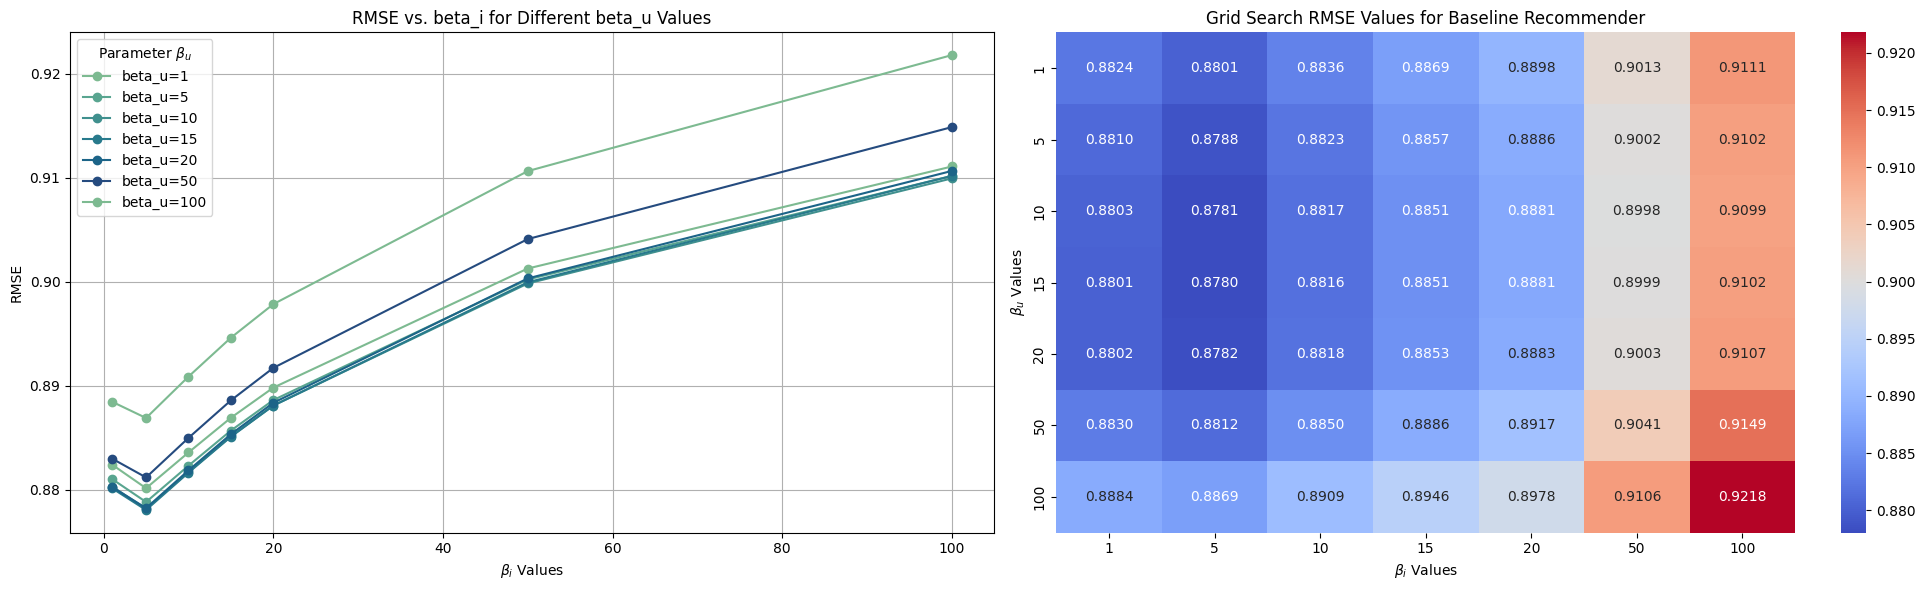

In [85]:
def plot_rmse_hyperparameters(beta_u_values, beta_i_values, results):
    rmses_matrix = np.zeros((len(beta_u_values), len(beta_i_values)))

    for params_string, metrics in results.items():
        params = eval(params_string)
        rmse = metrics[0]

        beta_u_idx = beta_u_values.index(params['beta_u'])
        beta_i_idx = beta_i_values.index(params['beta_i'])
        
        rmses_matrix[beta_u_idx, beta_i_idx] = rmse

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    for index, beta_u in enumerate(beta_u_values):
        plt.plot(beta_i_values, rmses_matrix[index], label=f'beta_u={beta_u}', marker='o')
    
    plt.title('RMSE vs. beta_i for Different beta_u Values')
    plt.xlabel(r"$\beta_i$ Values")
    plt.ylabel('RMSE')
    plt.legend(title=r'Parameter $\beta_u$')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.heatmap(rmses_matrix, annot=True, fmt=".4f", xticklabels=beta_i_values, yticklabels=beta_u_values, cmap='coolwarm')
    plt.title('Grid Search RMSE Values for Baseline Recommender')
    plt.xlabel(r"$\beta_i$ Values")
    plt.ylabel(r"$\beta_u$ Values")

    plt.tight_layout()
    plt.show()

plot_rmse_hyperparameters(param_grid['beta_u'], param_grid['beta_i'], results)

Shapewise both parameters $\beta_u$ and $\beta_i$ show the same trend. A clear crease at around $\beta_i=$

In [86]:
def output_best_metrics(results, best_params, best_rmse):
    best_params_str = str(best_params)
    best_metrics = results[best_params_str]
    
    print("--- Grid Search Results ---")
    print(f"Best Parameters: {best_params}")
    print(f"Best RMSE: {best_rmse:.4f}")    
    print(f"Best Average Precision@K: {best_metrics[1]:.4f}")
    print(f"Best Average Recall@K: {best_metrics[2]:.4f}")

        
output_best_metrics(results, best_params, best_rmse)

--- Grid Search Results ---
Best Parameters: {'beta_u': 15, 'beta_i': 5}
Best RMSE: 0.8780
Best Average Precision@K: 0.6315
Best Average Recall@K: 0.6736


In [80]:
result_store.add_result(recommender_name='BaselineRecommender', 
                        rmse=best_rmse, 
                        best_parameters=best_params, 
                        precision_at_k=None,
                        recall_at_k=None, 
                        exercise=4, 
                        results=results)

✅ Result added!


### Exercise 5 - Collaborative filtering item based and user based (10 points)
In this exersise we will build several different collaborative-filtering RS based on nearest neighbour technique, both in terms of item and user. 

Implement:
1. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
2. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 
3. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
4. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 

Each should have a default $K$ of 30.

Describe the two similarity metrics.


#### Defining a Base
In order to streamline the process of creating these different recommenders, I define a Base-Class `RecommenderSystemBase` that holds the structure and the base functions for the following recommenders.

The `RecommenderSystemBase` holds the following functions:
- `_cosine_similarity`: This function calculates the cosine similarity for the entire matrix (vectorized) along axis 1.
- `_pearson_correlation`: This function calculates the pearson correlation for the entire matrix (vectorized) along axis 1.


In [ ]:
class RecommenderSystemBase:
    def __init__(self, K=30):
        self.K = K
        self.similarities = None
        self.ratings_matrix = None

    def _cosine_similarity(self, matrix):
        norm = np.linalg.norm(matrix, axis=1, keepdims=True)
        norm_matrix = matrix / norm
        similarity = np.dot(norm_matrix, norm_matrix.T)
        np.fill_diagonal(similarity, 0)
        return similarity

    def _pearson_correlation(self, matrix):
        mean_centered = matrix - np.mean(matrix, axis=1, keepdims=True)
        corr_matrix = np.corrcoef(mean_centered)
        np.fill_diagonal(corr_matrix, 0)
        return corr_matrix

    def _find_nearest_neighbors(self, idx, exclude_idx=True):
        sorted_indices = np.argsort(-self.similarities[idx])[:self.K+1]
        if exclude_idx:
            sorted_indices = sorted_indices[sorted_indices != idx]
        return sorted_indices[:self.K]

### Item-Item Collaborative Filtering
$$p_{u,i}=\frac{\sum_{j\in S} s(i,j)(r_{u,j}-b_{u,j})}{\sum_{j\in S} |s(i,j)|}+b_{u,i}$$
#### K Most Similar Items: Cosine Similarity

In [ ]:
class ItemBasedCF_Cosine(RecommenderSystemBase):
    def __init__(self, K=30, baseline_recommender=None):
        super().__init__(K)
        self.baseline_recommender = baseline_recommender or BaselineRecommender()

    def fit(self, ratings_matrix):
        self.ratings_matrix = ratings_matrix
        self.baseline_recommender.fit(ratings_matrix)
        filled_matrix = np.nan_to_num(ratings_matrix, nan=0)
        self.similarities = self._cosine_similarity(filled_matrix.T)

    def predict(self, user_id, item_id):
        if not np.isnan(self.ratings_matrix[user_id, item_id]):
            return self.ratings_matrix[user_id, item_id]

        items = np.where(~np.isnan(self.ratings_matrix[user_id]))[0]
        num = denom = 0
        baseline_ui = self.baseline_recommender.predict(user_id, item_id)

        for j in items:
            baseline_uj = self.baseline_recommender.predict(user_id, j)
            rating_diff = self.ratings_matrix[user_id, j] - baseline_uj
            sim = self.similarities[item_id, j]
            num += sim * rating_diff
            denom += abs(sim)

        if denom == 0:
            return baseline_ui

        predicted_rating = num / denom + baseline_ui
        return predicted_rating

    def predict_multiple(self, user_ids, item_ids):
        predictions = []
        for user_id, item_id in zip(user_ids, item_ids):
            prediction = self.predict(user_id, item_id)
            predictions.append(prediction)
        return predictions


In [ ]:
item_cf = ItemBasedCF_Cosine(K=30)
item_cf.fit(user_item_matrix.values)

user_id = 0
item_id = 0

item_cf.predict_multiple([0,1], [0,1])

[4.0, 4.277395397405422]

#### K Most Similar Items: Pearson Correlation Coefficient

In [ ]:
class ItemBasedCF_Pearson(RecommenderSystemBase):
    def __init__(self, K=30, baseline_recommender=None):
        super().__init__(K)
        self.baseline_recommender = baseline_recommender or BaselineRecommender()

    def fit(self, ratings_matrix):
        self.ratings_matrix = ratings_matrix
        self.baseline_recommender.fit(ratings_matrix)
        filled_matrix = np.nan_to_num(ratings_matrix, nan=0)
        self.similarities = self._pearson_correlation(filled_matrix.T)

    def predict(self, user_id, item_id):
        if not np.isnan(self.ratings_matrix[user_id, item_id]):
            return self.ratings_matrix[user_id, item_id]

        items = np.where(~np.isnan(self.ratings_matrix[user_id]))[0]
        num = denom = 0
        baseline_ui = self.baseline_recommender.predict(user_id, item_id)

        for j in items:
            baseline_uj = self.baseline_recommender.predict(user_id, j)
            rating_diff = self.ratings_matrix[user_id, j] - baseline_uj
            sim = self.similarities[item_id, j]
            num += sim * rating_diff
            denom += abs(sim)

        if denom == 0:
            return baseline_ui

        predicted_rating = num / denom + baseline_ui
        return predicted_rating

    def predict_multiple(self, user_ids, item_ids):
        predictions = []
        for user_id, item_id in zip(user_ids, item_ids):
            prediction = self.predict(user_id, item_id)
            predictions.append(prediction)
        return predictions


In [ ]:
best_params, best_rmse, results = grid_search_cv(user_item_matrix.values, ItemBasedCF_Cosine, { 'K': [1, 5, 10, 20, 30, 50]}, mask_ratio=0.3)

#### K Most Similar Users: Cosine Similarity

In [ ]:
class UserBasedCF_Cosine(RecommenderSystemBase):
    def fit(self, ratings_matrix):
        self.ratings_matrix = ratings_matrix
        filled_matrix = np.nan_to_num(ratings_matrix, nan=0)
        self.similarities = self._cosine_similarity(filled_matrix)

    def predict(self, user_id, item_id):
        if not np.isnan(self.ratings_matrix[user_id, item_id]):
            return self.ratings_matrix[user_id, item_id]

        neighbors = self._find_nearest_neighbors(user_id)
        num = denom = 0
        user_mean = np.nanmean(self.ratings_matrix[user_id])
        user_std = np.nanstd(self.ratings_matrix[user_id])

        if user_std == 0:
            user_std = 1

        for neighbor in neighbors:
            if not np.isnan(self.ratings_matrix[neighbor, item_id]):
                neighbor_mean = np.nanmean(self.ratings_matrix[neighbor])
                neighbor_std = np.nanstd(self.ratings_matrix[neighbor])

                if neighbor_std == 0:
                    continue

                rating_diff = (self.ratings_matrix[neighbor, item_id] - neighbor_mean) / neighbor_std
                sim = self.similarities[user_id, neighbor]
                num += sim * rating_diff
                denom += abs(sim)

        if denom == 0:
            return user_mean

        predicted_rating = user_mean + (user_std * num / denom)
        return predicted_rating

    def predict_multiple(self, user_ids, item_ids):
        predictions = []
        for user_id, item_id in zip(user_ids, item_ids):
            prediction = self.predict(user_id, item_id)
            predictions.append(prediction)
        return predictions

In [ ]:
cf = UserBasedCF_Cosine(K=30)
cf.fit(user_item_matrix.values)

In [ ]:
params = {
    'K': [30]
}

best_params, best_rmse, results = grid_search_cv(user_item_matrix.values, UserBasedCF_Cosine, params, mask_ratio=0.3)

In [ ]:
output_best_metrics(results, best_params, best_rmse)

--- Grid Search Results ---
Best Parameters: {'K': 30}
Best RMSE: 0.9155
Best Average Precision@K: 0.5386
Best Average Recall@K: 0.6862


In [ ]:
user_cf = UserBasedCF_Cosine(K=30)
user_cf.fit(user_item_matrix.values)

user_id = [0, 1, 2, 3]
movie_id = [0, 1, 2, 3]

user_cf.predict(0, 1)

4.028254687808545

In [ ]:
user_cf = UserBasedCF_Cosine(K=30)
user_cf.fit(user_item_matrix.values)

user_id = 1
item_id = 1

user_cf.predict(1, 1)

3.8572669949605425

#### K Most Similar Users: Pearson Correlation Coefficient

In [ ]:
class UserBasedCF_Pearson(RecommenderSystemBase):
    def fit(self, ratings_matrix):
        self.ratings_matrix = ratings_matrix
        filled_matrix = np.nan_to_num(ratings_matrix, nan=0)
        self.similarities = self._pearson_correlation(filled_matrix)

    def predict(self, user_id, item_id):
        if not np.isnan(self.ratings_matrix[user_id, item_id]):
            return self.ratings_matrix[user_id, item_id]

        neighbors = self._find_nearest_neighbors(user_id)
        num = denom = 0
        user_mean = np.nanmean(self.ratings_matrix[user_id])
        user_std = np.nanstd(self.ratings_matrix[user_id])

        if user_std == 0:
            user_std = 1

        for neighbor in neighbors:
            if not np.isnan(self.ratings_matrix[neighbor, item_id]):
                neighbor_mean = np.nanmean(self.ratings_matrix[neighbor])
                neighbor_std = np.nanstd(self.ratings_matrix[neighbor])

                if neighbor_std == 0:
                    continue

                rating_diff = (self.ratings_matrix[neighbor, item_id] - neighbor_mean) / neighbor_std
                sim = self.similarities[user_id, neighbor]
                num += sim * rating_diff
                denom += abs(sim)

        if denom == 0:
            return user_mean

        predicted_rating = user_mean + (user_std * num / denom)
        return predicted_rating

    def predict_multiple(self, user_ids, item_ids):
        predictions = []
        for user_id, item_id in zip(user_ids, item_ids):
            prediction = self.predict(user_id, item_id)
            predictions.append(prediction)
        return predictions

In [ ]:
user_cf_pearson = UserBasedCF_Pearson(K=30)
user_cf_pearson.fit(user_item_matrix.values)

user_id = 1
item_id = 1

user_cf_pearson.predict(user_id, item_id)

3.8572669949605425

In [ ]:
# get top ratings for userbased pearson
user_ids = [1, 50, 100]

for user_id in user_ids:
    recommendations = []
    for item_id in range(1, user_item_matrix.shape[1] + 1):
        if np.isnan(user_item_matrix[user_id - 1, item_id - 1]):
            user_item_matrix[user_id - 1, item_id - 1] = user_cf_pearson.predict(user_id, item_id)
            
        print(user_cf_pearson.predict(user_id, item_id)
    print(f" - User {user_id} Recommendations")
    print(recommendations)


 - User 1 Recommendations
3.8572669949605425
 - User 50 Recommendations
4.5
 - User 100 Recommendations
3.122347736653135


#### Cosine Similarity vs. Pearson Correlation Coefficient

- **Cosine Similarity:** 
- **Pearson Correlation Coefficient:**

### Exercise 6 - Optimize hyperparameter $K$ (6 points)
Optimize the hyperparameter $K$ for all RS from the prior exercise optimizing for minimal RMSE. 
For each RS plot RMSE, Precision@N and Recall@N as a function of $K$. 

Compare the results of these four RS on the 3 example users. Do the results match your expectation? Describe.

In [ ]:
def optimize_cf_recommenders(recommenders: list=[], param_grid: dict={}):
    optimization_results = {}
    
    for recommender in recommenders:
        print(f'--- Optimizing {recommender.__name__} ---')
        best_params, best_rmse, individual_results = grid_search_cv(user_item_matrix.values, recommender, param_grid, parallel=True)
        
        print(f"Best Parameters for {recommender.__name__}: {best_params}")
        print(f"Best RMSE for {recommender.__name__}: {best_rmse}\n")
        
        optimization_results[recommender.__name__] = {
            'best_params': best_params,
            'best_rmse': best_rmse,
            'results': individual_results
        }
        
    return optimization_results

param_grid = { 'K': [1, 5, 30, 50] }

cf_results = optimize_cf_recommenders(recommenders=[
                                    UserBasedCF_Cosine, 
                                    UserBasedCF_Pearson, 
                                    ItemBasedCF_Cosine, 
                                    ItemBasedCF_Pearson
                                    ],
                                   param_grid=param_grid)

--- Optimizing UserBasedCF_Cosine ---
Best Parameters for UserBasedCF_Cosine: {'K': 50}
Best RMSE for UserBasedCF_Cosine: 0.9074767419642666

--- Optimizing UserBasedCF_Pearson ---
Best Parameters for UserBasedCF_Pearson: {'K': 50}
Best RMSE for UserBasedCF_Pearson: 0.9109115400795755

--- Optimizing ItemBasedCF_Cosine ---
Best Parameters for ItemBasedCF_Cosine: {'K': 1}
Best RMSE for ItemBasedCF_Cosine: 0.9242536478705825

--- Optimizing ItemBasedCF_Pearson ---
Best Parameters for ItemBasedCF_Pearson: {'K': 1}
Best RMSE for ItemBasedCF_Pearson: 0.9205171731188173



--- UserBasedCF_Cosine ---


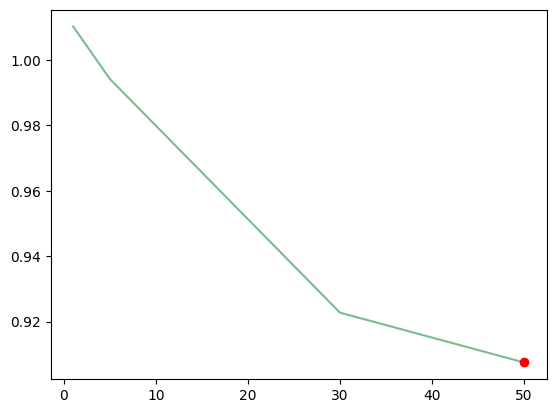

--- UserBasedCF_Pearson ---


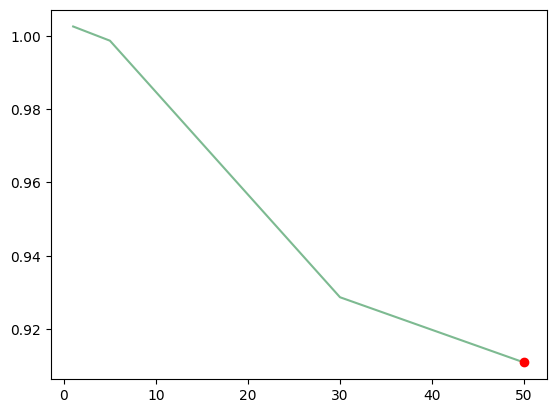

--- ItemBasedCF_Cosine ---


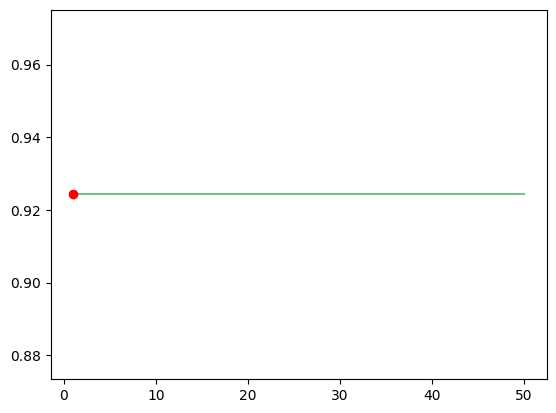

--- ItemBasedCF_Pearson ---


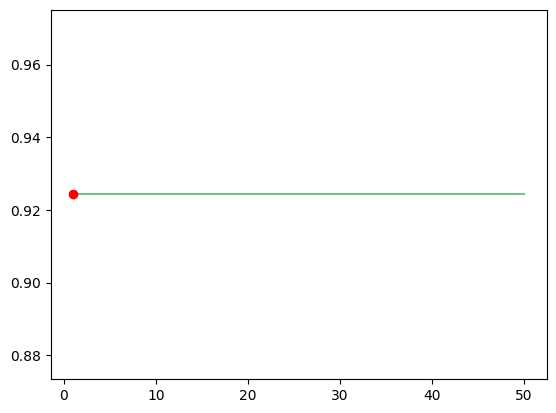

In [ ]:
for cf in cf_results:
    print(f"--- {cf} ---")
    
    plt.plot(param_grid['K'], [r[1] for r in cf_results[cf]['results']])
    plt.plot(cf_results[cf]['best_params']['K'], cf_results[cf]['best_rmse'], 'ro')
    plt.show()

### Excercise 7 - Model-based RS: SVD (6 points)
In this exercise we will use the unsupervised method *singular value decomposition (SVD)* from the python package *surprise* (https://surpriselib.com, documentation https://surprise.readthedocs.io/en/stable/matrix_factorization.html) or the R package *recommenderlab*. SVD can compress much of the information of a matrix in few components.  

Run the SVD RS and show the results on the three example users from exercise 2. Explain how this algorithm works.

Note: A very good general introduction to SVD is this youtube video series starting with https://www.youtube.com/watch?v=gXbThCXjZFM&t=337s . See *Collaborative filtering recommender systems* by Ekstrand et al. *Mining of massive datasets* by Leskovec, Kapitel 11 (2020) and ,*Recommender systems: The textbook*, by Aggarwal, chapter 3

In [ ]:
import pandas as pd
from surprise import SVD, Dataset, Reader

class SVDRecommender:
    def __init__(self, n_factors=50, random_state=1337, rating_scale=(0, 5)):
        self.n_factors = n_factors
        self.random_state = random_state
        self.rating_scale = rating_scale
        self.svd = SVD(n_factors=self.n_factors, random_state=self.random_state)
        self.reader = Reader(rating_scale=self.rating_scale)
        self.user_item_matrix = None

    def fit(self, user_item_matrix):
        if not isinstance(user_item_matrix, np.ndarray):
            raise ValueError("user_item_matrix must be a numpy array")

        self.user_item_matrix = user_item_matrix
        
        data = pd.DataFrame(user_item_matrix)
        data = data.stack().reset_index()
        data = data.rename(columns={'level_0': 'userId', 'level_1': 'itemId', 0: 'rating'})
        data = data.dropna(subset=['rating'])
        
        surprise_data = Dataset.load_from_df(data[['userId', 'itemId', 'rating']], self.reader)
        trainset = surprise_data.build_full_trainset()
        self.svd.fit(trainset)

    def predict(self, user, item):
        if not np.isnan(self.user_item_matrix[user, item]):
            return self.user_item_matrix[user, item]

        return self.svd.predict(user, item).est

In [ ]:
np.random.seed(1337)

user_ids = np.random.choice(user_item_matrix.shape[0], 3, replace=False)

svd = SVDRecommender(n_factors=50, random_state=1337)
svd.fit(user_item_matrix.values)

for user_id in user_ids:
    recommendations = []
    
    print(f"--- User {user_id} Recommendations:")
    for movie_id in range(1, user_item_matrix.shape[1]):
        if np.isnan(user_item_matrix.values[user_id - 1, movie_id - 1]):
            recommendations.append((movie_id, svd.predict(user_id, movie_id)))
    recommendations.sort(key=lambda x: x[1], reverse=True)
    df_svd_recs = pd.DataFrame(recommendations[:5], columns=['movieId', 'predicted_rating'])
    df_svd_recs = pd.merge(df_svd_recs, df_movies, how='inner', left_on='movieId', right_on='movieId_seq')
    
    display(df_svd_recs[['title', 'predicted_rating']])
    
    print()

--- User 559 Recommendations:


,title,predicted_rating
0,Spirits of the Dead (1968),4.5
1,Broken English (1996),4.5
2,Witness (1985),4.5
3,Kundun (1997),4.5
4,Next Stop Wonderland (1998),4.5



--- User 80 Recommendations:


,title,predicted_rating
0,Dangerous Minds (1995),5.0
1,Aladdin (1992),5.0
2,"Specialist, The (1994)",4.0
3,Tales from the Crypt Presents: Demon Knight (1...,4.0
4,Fresh (1994),4.0



--- User 545 Recommendations:


,title,predicted_rating
0,Friday (1995),5.0
1,Aladdin (1992),5.0
2,"Graduate, The (1967)",5.0
3,Deceiver (1997),5.0
4,Take the Money and Run (1969),5.0


#### How SVD works

### Exercise 8 - Optimize hyperparameter $k$ or `n_factors` (4 points)
Optimize the hyperparameter, representing the number of greatest SVD components used for the truncated reconstruction of the user item matrix, to minimize RMSE.
Plot RMSE, Precision@N and Recall@N as a function of this hyperparameter. Finally output all performance metrics from exercise 3 for the found value.

In [ ]:
best_params, best_rmse, results = grid_search_cv(user_item_matrix.values, SVDRecommender, {'n_factors': [1, 2, 3, 5, 10, 50, 100, 150, 200, 250, 300, 350]})

In [ ]:
output_best_metrics(results, best_params, best_rmse)

--- Grid Search Results ---
Best Parameters: {'n_factors': 3}
Best RMSE: 0.8730
Best Average Precision@K: 0.7316
Best Average Recall@K: 0.4370


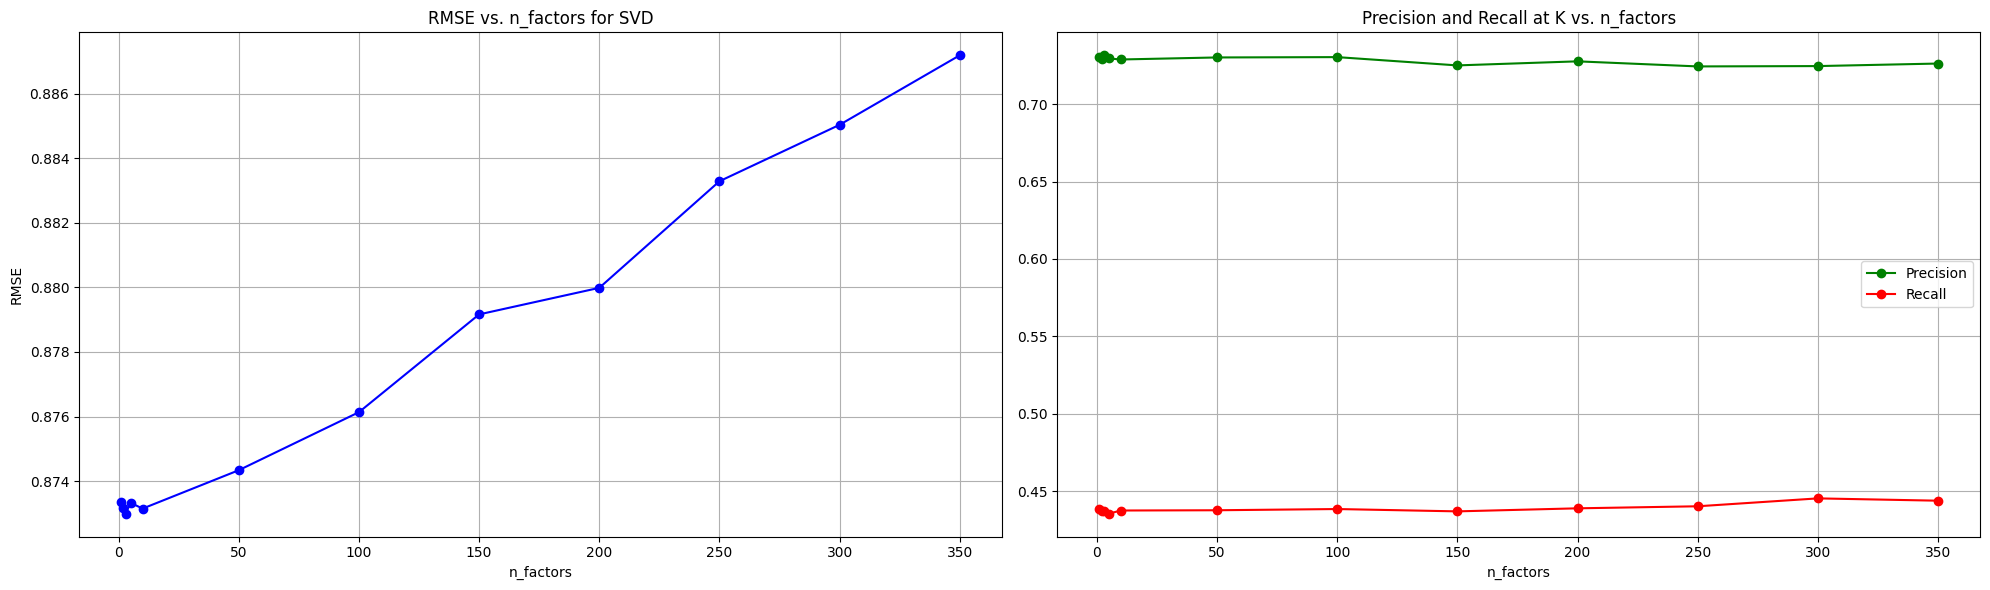

In [ ]:
rmse_values = [result[1] for result in results]
precision_values = [result[2] for result in results]
recall_values = [result[3] for result in results]
n_factors = [params['n_factors'] for params, _, _, _ in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(n_factors, rmse_values, marker='o', color='blue')
ax1.set_title('RMSE vs. n_factors for SVD')
ax1.set_xlabel('n_factors')
ax1.set_ylabel('RMSE')
ax1.grid(True)

ax2.plot(n_factors, precision_values, marker='o', label='Precision', color='green')
ax2.plot(n_factors, recall_values, marker='o', label='Recall', color='red')
ax2.set_title('Precision and Recall at K vs. n_factors')
ax2.set_xlabel('n_factors')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Exercise 9 - Everything goes (30 points)
In this exercise you can explore different methods of RS. You are not limited what methods you apply. You can try to improve the methods from the earlier exercises by adjusting them or generating ensemble or hybrid RS. Also you can train deep neural networks, use NLP methods, use the available links to imdb available in the dataset to further enrich the dataset or find an obscure method by someone else on Github. However document what your inspirations and sources are and your process. Important: If you use the work of someone else you must be able to explain the method conceptually. 
Output the performance metrics of exercise 3.

**Build and optimize at least three different methods.**

### A Hybrid Approach

In [ ]:
class HybridRecommender:
    def __init__(self, user_based_cf=None, item_based_cf=None, svd=None, weights=[0.333, 0.333, 0.333]):
        self.user_based_cf = user_based_cf() if user_based_cf is not None else UserBasedCF_Cosine()
        self.item_based_cf = item_based_cf() if item_based_cf is not None else ItemBasedCF_Cosine()
        self.svd = svd() if svd is not None else SVDRecommender()
        self.weights = weights

    def fit(self, ratings_matrix):
        self.user_based_cf.fit(ratings_matrix=ratings_matrix)
        self.item_based_cf.fit(ratings_matrix)
        self.svd.fit(ratings_matrix)

    def predict(self, user_id, item_id):
        user_based_prediction = self.user_based_cf.predict(user_id, item_id)
        item_based_prediction = self.item_based_cf.predict(user_id, item_id)
        svd_prediction = self.svd.predict(user_id, item_id)

        hybrid_prediction = sum([w * p for w, p in zip(self.weights, [user_based_prediction, item_based_prediction, svd_prediction])])
        
        return hybrid_prediction

    def predict_multiple(self, user_ids, item_ids):
        predictions = []
        for user_id, item_id in zip(user_ids, item_ids):
            prediction = self.predict(user_id, item_id)
            predictions.append(prediction)
        return predictions

In [ ]:
param_grid = {
    'weights': [
            [0.333, 0.333, 0.333], 
            [0.5, 0.25, 0.25], 
            [0.25, 0.5, 0.25], 
            [0.25, 0.25, 0.5]
        ]
    }

best_params, best_rmse, results = grid_search_cv(user_item_matrix.values, HybridRecommender, param_grid)

In [ ]:
output_best_metrics(results, best_params, best_rmse)

--- Grid Search Results ---
Best Parameters: {'weights': [0.25, 0.25, 0.5]}
Best RMSE: 0.8595
Best Average Precision@K: 0.7097
Best Average Recall@K: 0.5380


#### Temporal Recommendation

1. Encode Movies

Preparing the data

In [ ]:
df_movieratings.sort_values(by=['userId', 'timestamp'], inplace=True)

user_sequences = df_movieratings.groupby('userId')['movieId_seq'].apply(list).to_dict()

def generate_context_pairs(sequence, window_size=1):
    pairs = []
    for i in range(len(sequence)):
        target = sequence[i]
        context_indices = range(max(0, i-window_size), min(len(sequence), i+window_size+1))
        for j in context_indices:
            if i != j:
                context = sequence[j]
                pairs.append((target, context))
    return pairs

window_size = 1
all_pairs = []

for user_id, movies in user_sequences.items():
    user_pairs = generate_context_pairs(movies, window_size=window_size)
    all_pairs.extend(user_pairs)

df_pairs = pd.DataFrame(all_pairs, columns=['TargetMovieId', 'ContextMovieId'])

In [ ]:
np.unique(df_pairs['TargetMovieId'].values).shape[0]

9724

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [ ]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset

target_tensors = torch.tensor(df_pairs['TargetMovieId'].values, dtype=torch.long)
context_tensors = torch.tensor(df_pairs['ContextMovieId'].values, dtype=torch.long)

dataset = TensorDataset(target_tensors, context_tensors)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 160361
Number of testing samples: 40091


In [ ]:
import torch.nn as nn
import torch.optim as optim

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_words):
        embedded = self.embeddings(input_words)
        out = self.output_layer(embedded)
        return out

In [ ]:
vocab_size = df_pairs[['TargetMovieId', 'ContextMovieId']].max().max()  
embedding_dim = 128
learning_rate = 0.01
epochs = 1

embedding_model = SkipGramModel(vocab_size=vocab_size + 1, embedding_dim=embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(embedding_model.parameters(), lr=learning_rate)

embedding_model = embedding_model.to(device)

for epoch in range(epochs):
    embedding_model.train()
    for batch in train_dataloader:
        target, context = batch
        target = target.to(device)
        context = context.to(device)

        optimizer.zero_grad()
        output = embedding_model(target)
        loss = criterion(output, context)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 8.921525001525879


In [ ]:
def get_movie_embedding(model, movie_id):
    movie_id_tensor = torch.tensor([movie_id], dtype=torch.long, device=device)
    with torch.no_grad():
        movie_embedding = model.embeddings(movie_id_tensor)
    return movie_embedding

def get_multiple_movie_embeddings(model, movie_ids):
    movie_ids_tensor = torch.tensor(movie_ids, dtype=torch.long, device=device)
    with torch.no_grad():
        embeddings = model.embeddings(movie_ids_tensor)
    return embeddings

movie_id = 1 
embedding = get_movie_embedding(embedding_model, movie_id)
print("Embedding for movie ID", movie_id, ":", embedding.shape)

Embedding for movie ID 1 : torch.Size([1, 128])


In [ ]:
from torch.utils.data import DataLoader, Dataset

class MovieSequenceDataset(Dataset):
    def __init__(self, df, seq_length, embed_model):
        self.embed_model = embed_model
        self.embed_model.eval()  # Ensure the model is in evaluation mode
        self.df = df.groupby('userId')['movieId_seq'].apply(list)
        self.sequences = []
        self.labels = []
        for user_sequence in self.df:
            for i in range(len(user_sequence) - seq_length):
                self.sequences.append(user_sequence[i:i+seq_length])
                self.labels.append(user_sequence[i+seq_length])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sequence_embeddings = torch.stack([self.embed_model.embeddings(torch.tensor(mid, dtype=torch.long).to(device)) for mid in self.sequences[idx]])
        label_embedding = self.embed_model.embeddings(torch.tensor(self.labels[idx], dtype=torch.long).to(device))
        
        return sequence_embeddings, label_embedding

seq_length = 5 
dataset = MovieSequenceDataset(df_movieratings, seq_length, model)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class MoviePredictorRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MoviePredictorRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        out = self.linear(out[:, -1, :])
        return out

input_dim = 128
hidden_dim = 128
num_layers = 2
output_dim = 128

rnn_model = MoviePredictorRNN(input_dim, hidden_dim, num_layers, output_dim)

In [ ]:
def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss / len(train_loader):.4f}')
    print('Training complete')

rnn_model.to(device)

num_epochs = 10
learning_rate = 0.01

train_model(rnn_model, train_loader, num_epochs, learning_rate)

Epoch [1/10], Train Loss: 0.2976
Epoch [2/10], Train Loss: 0.2961
Epoch [3/10], Train Loss: 0.2954
Epoch [4/10], Train Loss: 0.2948
Epoch [5/10], Train Loss: 0.2943
Epoch [6/10], Train Loss: 0.2938
Epoch [7/10], Train Loss: 0.2934
Epoch [8/10], Train Loss: 0.2929
Epoch [9/10], Train Loss: 0.2926
Epoch [10/10], Train Loss: 0.2923
Training complete


In [ ]:
movie_embeddings = embedding_model.embeddings.weight.cpu().detach().numpy()

movie_seq = [244, 1, 61, 3, 9]

# import cosine sim
from sklearn.metrics.pairwise import cosine_similarity

embeddings = get_multiple_movie_embeddings(embedding_model, movie_seq)

pred = rnn_model(embeddings.unsqueeze(0)).cpu()

similarities = cosine_similarity(pred.detach().numpy(), movie_embeddings)

similar_movies = np.argmax(similarities, axis=1)

print(similar_movies)

[5980]


### Exercise 10 - Compare all RS that you build in this challenge (6 points)
Compile a table with the performance metrics of exercise 3 for all RS from this MC (Make sure to include also the baseline RS). Also generate comparative plots. Discuss.

### Exercise 11 - Risks of RS on user or society (5 points)
In this exercise we take one step back from the technical aspects of RS.
Positive effects of good recommendations are easy to imagine: Happy customers and successful companies. However  also come with potential risks. Which risks for the user or society can you imagine or discover online? Pick one risk and describe what you would do to mitigate this problem.

#### Filter Bubbles
...

**Read the Guidelines for Implementation and Submission one more time.**